## 第9章 贝叶斯算法和K-近邻算法

In [4]:
## 输出高清图像
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
## 图像显示中文的问题
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False

import seaborn as sns 
sns.set(font= "Kaiti",style="ticks",font_scale=1.4)

import pandas as pd
pd.set_option("max_colwidth", 100)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB,GaussianNB,BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.preprocessing import label_binarize,KBinsDiscretizer
from mlxtend.plotting import plot_confusion_matrix,plot_decision_regions
from sklearn.manifold import TSNE
from sklearn.decomposition import SparsePCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from pandas.plotting import parallel_coordinates
import sef

## pgmpy库
import networkx as nx
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator,HillClimbSearch,ExhaustiveSearch
from pgmpy.estimators import BicScore
from graphviz import Digraph

## 忽略提醒
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'graphviz'

### 9.2 贝叶斯分类算法

#### 9.2.1 文本数据准备与可视化

In [11]:
## 读取数据，数据预处理，特征获取
bbcdf = pd.read_csv("data/chap9/bbcdata.csv")
print(bbcdf.head())

           label  labelcode  \
0  entertainment          4   
1  entertainment          4   
2  entertainment          4   
3  entertainment          4   
4  entertainment          4   

                                                                                              text_pre  
0  musicians to tackle us red tape musicians groups are to tackle us visa regulations which are bla...  
1  us desire to be number one u who have won three prestigious grammy awards for their hit vertigo ...  
2  rocker doherty in onstage fight rock singer pete doherty has been involved in a fight with his b...  
3  snicket tops us box office chart the film adaptation of lemony snicket novels has topped the nor...  
4  oceans twelve raids box office oceans twelve the crime caper sequel starring george clooney brad...  


In [13]:
## 查看每类数据有多少个样本
pd.value_counts(bbcdf.label)

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: label, dtype: int64

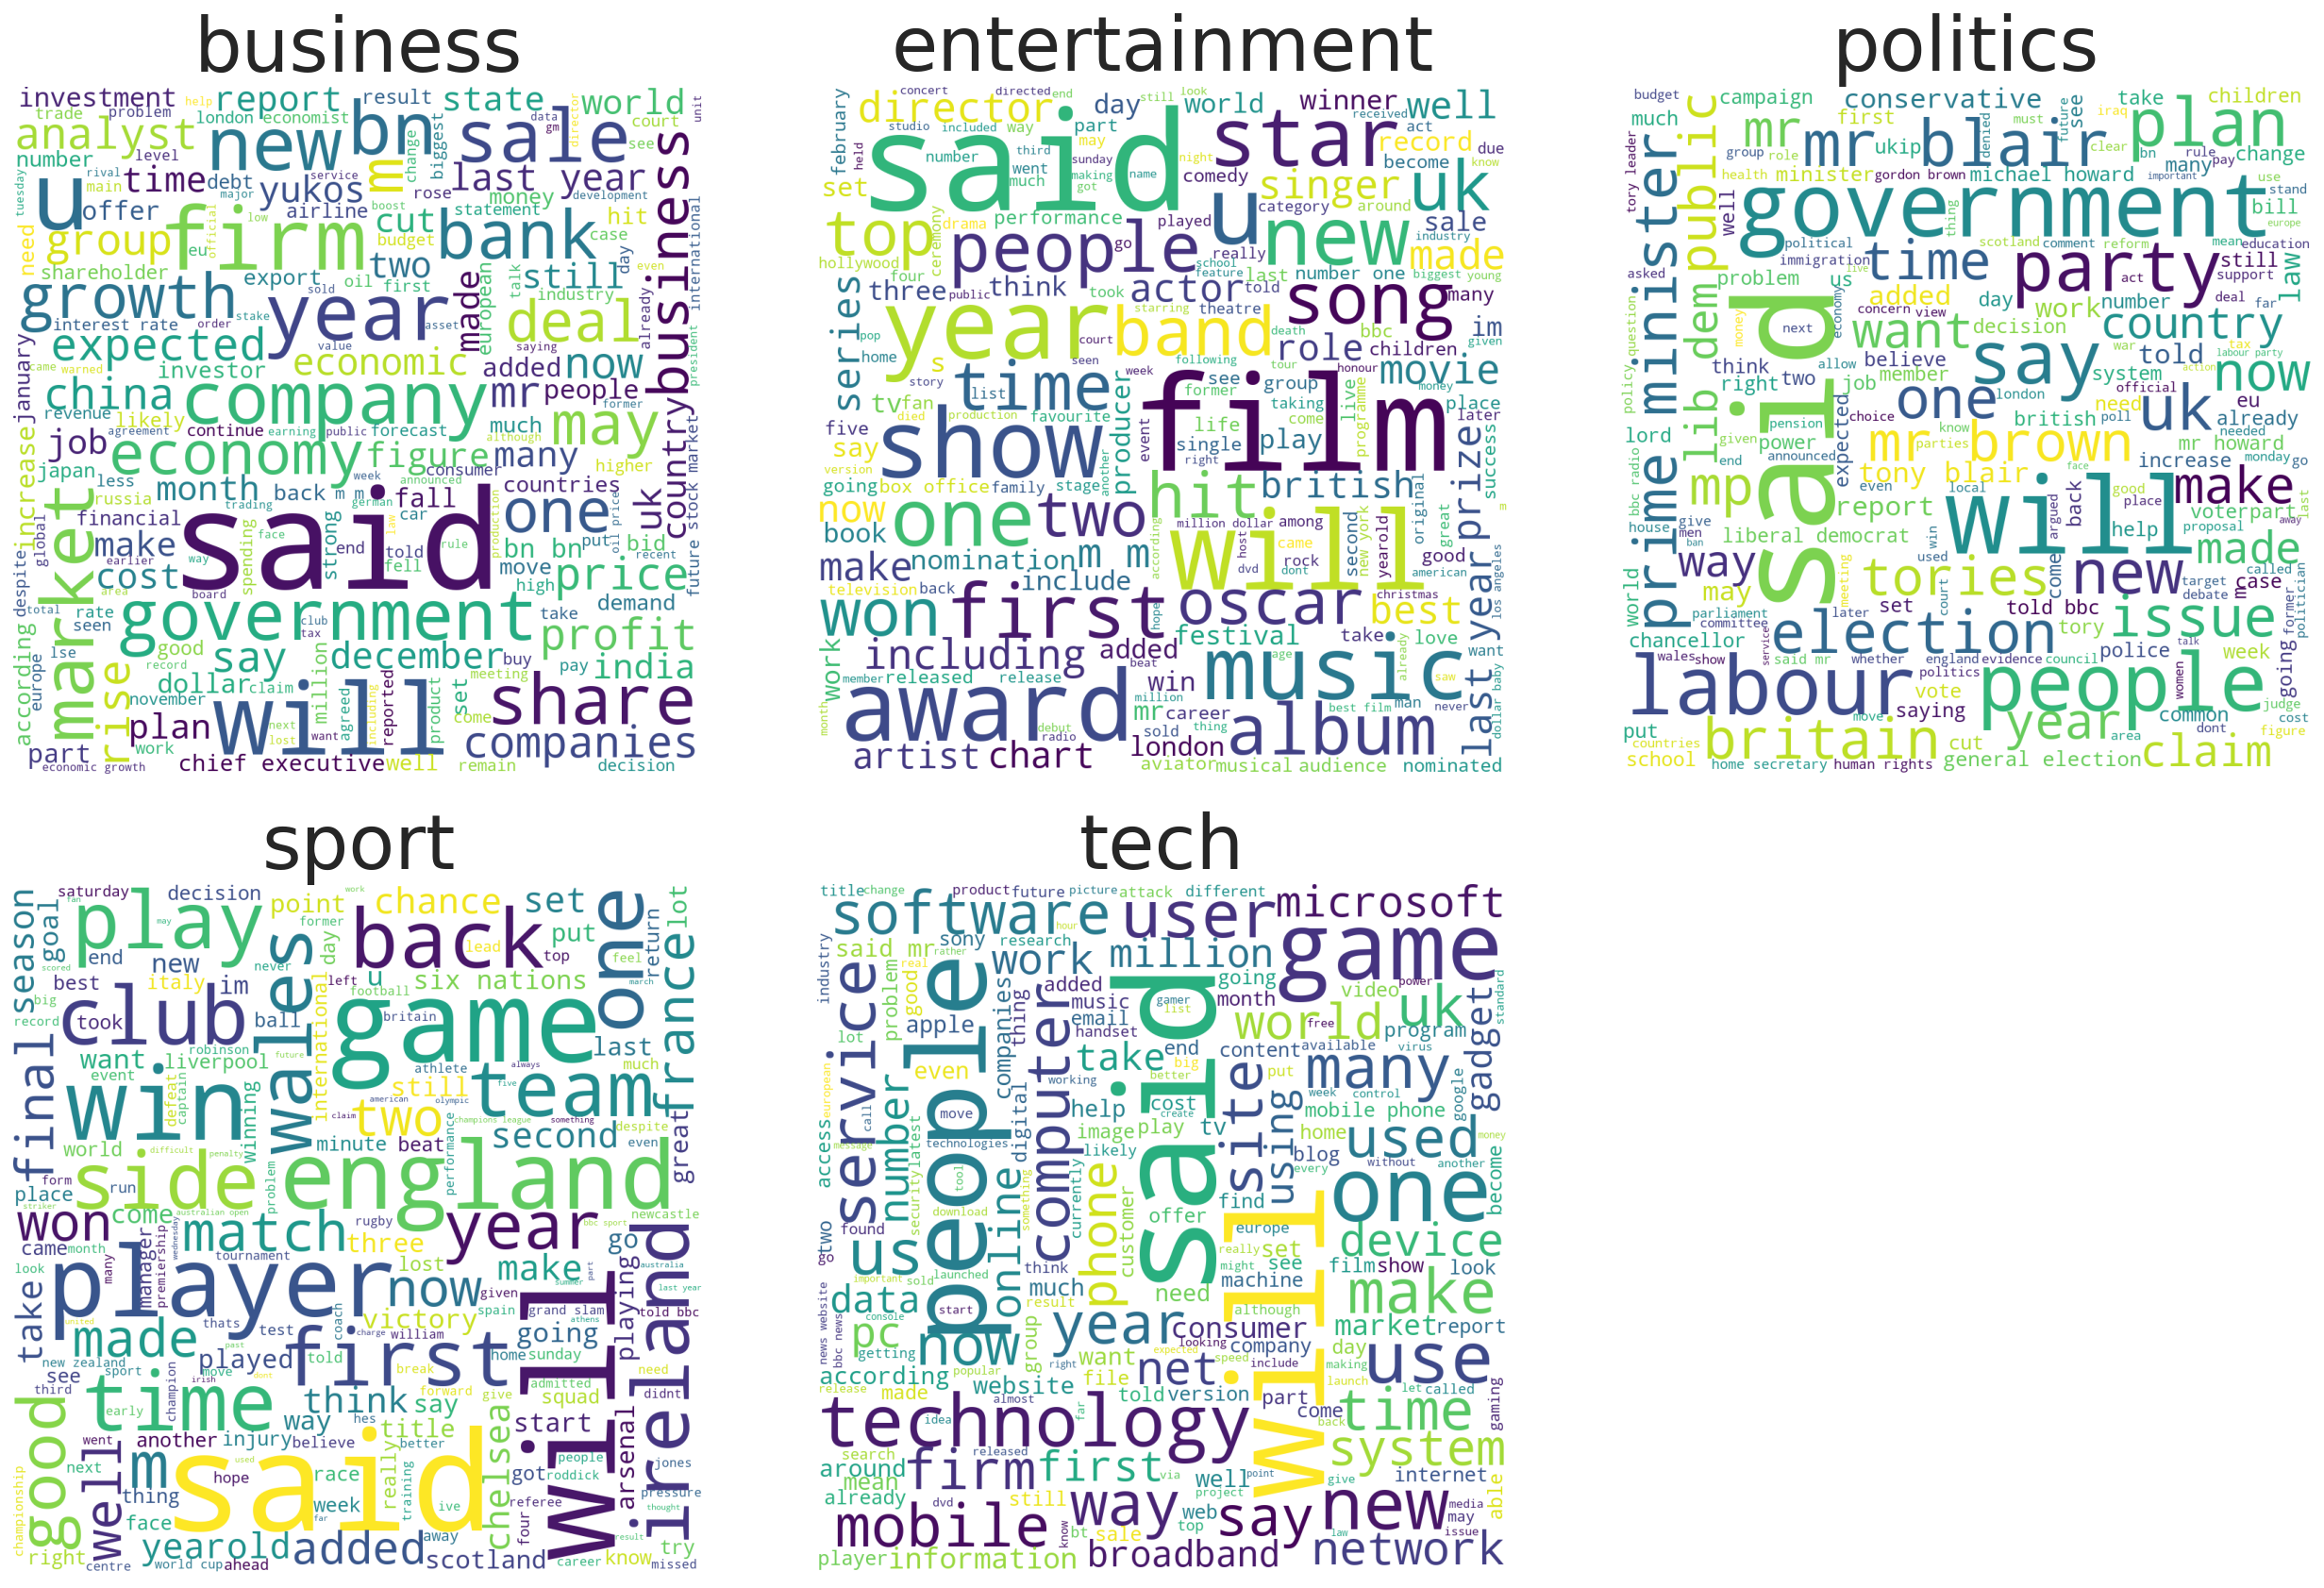

In [16]:
## 使用词云可视化不同类别数据的情况
classification = np.unique(bbcdf.label)
plt.figure(figsize=(18,12))
for ii,cla in enumerate(classification):
    text = bbcdf.text_pre[bbcdf.label == cla]
    ## 设置词云参数
    WordC = WordCloud(margin=1,width=1000, height=1000,
                      max_words=200, min_font_size=10, 
                      background_color="white",max_font_size=200)
    WordC.generate_from_text(" ".join(text))
    plt.subplot(2,3,ii+1)
    plt.imshow(WordC)
    plt.title(cla,size = 40)
    plt.axis("off")
plt.tight_layout()
plt.show()    

In [15]:
## 数据切分，训练集70%，测试集30%
X_train,X_test,y_train,y_test = train_test_split(
    bbcdf.text_pre,bbcdf.labelcode,test_size = 0.3, random_state=0)
print("X_train.shape:",X_train.shape)
print("X_test.shape:",X_test.shape)
## 获取数据的TF-IDF特征
vectorizer = CountVectorizer(stop_words="english",ngram_range=(1,2),
                             max_features=4000)    
transformer = TfidfTransformer()
## 获取训练集的特征
train_tfidf = transformer.fit_transform(vectorizer.fit_transform(X_train))
train_tfidf = train_tfidf.toarray()
print("train_tfidf.shape",train_tfidf.shape)
## 获取测试集的特征
test_tfidf = transformer.transform(vectorizer.transform(X_test))
test_tfidf = test_tfidf.toarray()
print("test_tfidf.shape",test_tfidf.shape)


## 每个样本转化为了维度为4000的特征向量

X_train.shape: (1557,)
X_test.shape: (668,)
train_tfidf.shape (1557, 4000)
test_tfidf.shape (668, 4000)


In [7]:
# np.savez("data/bbc_tfidf.npz",train_tfidf,test_tfidf,y_train,y_test)

**在scikit-learn中，一共有3种朴素贝叶斯的分类算法类。分别是GaussianNB，MultinomialNB和BernoulliNB。**

其中GaussianNB就是先验为高斯分布的朴素贝叶斯

MultinomialNB就是先验为多项式分布的朴素贝叶斯

BernoulliNB就是先验为伯努利分布的朴素贝叶斯

#### 9.2.2 朴素贝叶斯文本分类
 

In [8]:
## 建立先验为高斯分布的朴素贝叶斯模型
gnb = GaussianNB().fit(train_tfidf, y_train)
gnb_pre = gnb.predict(test_tfidf)
print(classification_report(y_test,gnb_pre))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       152
           1       0.92      0.93      0.93       152
           2       0.92      0.91      0.92       129
           3       0.83      0.97      0.89       117
           4       0.97      0.82      0.89       118

    accuracy                           0.93       668
   macro avg       0.93      0.92      0.92       668
weighted avg       0.93      0.93      0.93       668



In [9]:
## 建立先验为多项式分布的朴素贝叶斯模型
mnb = MultinomialNB().fit(train_tfidf, y_train)
mnb_pre = mnb.predict(test_tfidf)
print(classification_report(y_test,mnb_pre))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       152
           1       0.97      0.99      0.98       152
           2       0.95      0.98      0.97       129
           3       0.94      0.93      0.94       117
           4       0.99      0.93      0.96       118

    accuracy                           0.97       668
   macro avg       0.97      0.97      0.97       668
weighted avg       0.97      0.97      0.97       668



In [10]:
## 建立先验为伯努利分布的朴素贝叶斯模型
bnb = BernoulliNB().fit(train_tfidf, y_train)
bnb_pre = bnb.predict(test_tfidf)
print(classification_report(y_test,bnb_pre))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       152
           1       0.90      0.99      0.95       152
           2       0.99      0.94      0.96       129
           3       0.96      0.92      0.94       117
           4       0.98      0.96      0.97       118

    accuracy                           0.96       668
   macro avg       0.97      0.96      0.96       668
weighted avg       0.96      0.96      0.96       668



In [11]:
## 为方便后面可视化ROC曲线，对标签使用label_binarize进行编码
y_test_lb = label_binarize(y_test,classes=[0,1,2,3,4])
y_test_lb[0:5,:]
## 第0类数据被编码为:[1, 0, 0, 0, 0];第1类数据被编码为:[0, 1, 0, 0, 0]
## 第2类数据被编码为:[0, 0, 1, 0, 0];第3类数据被编码为:[0, 0, 0, 1, 0] 等

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

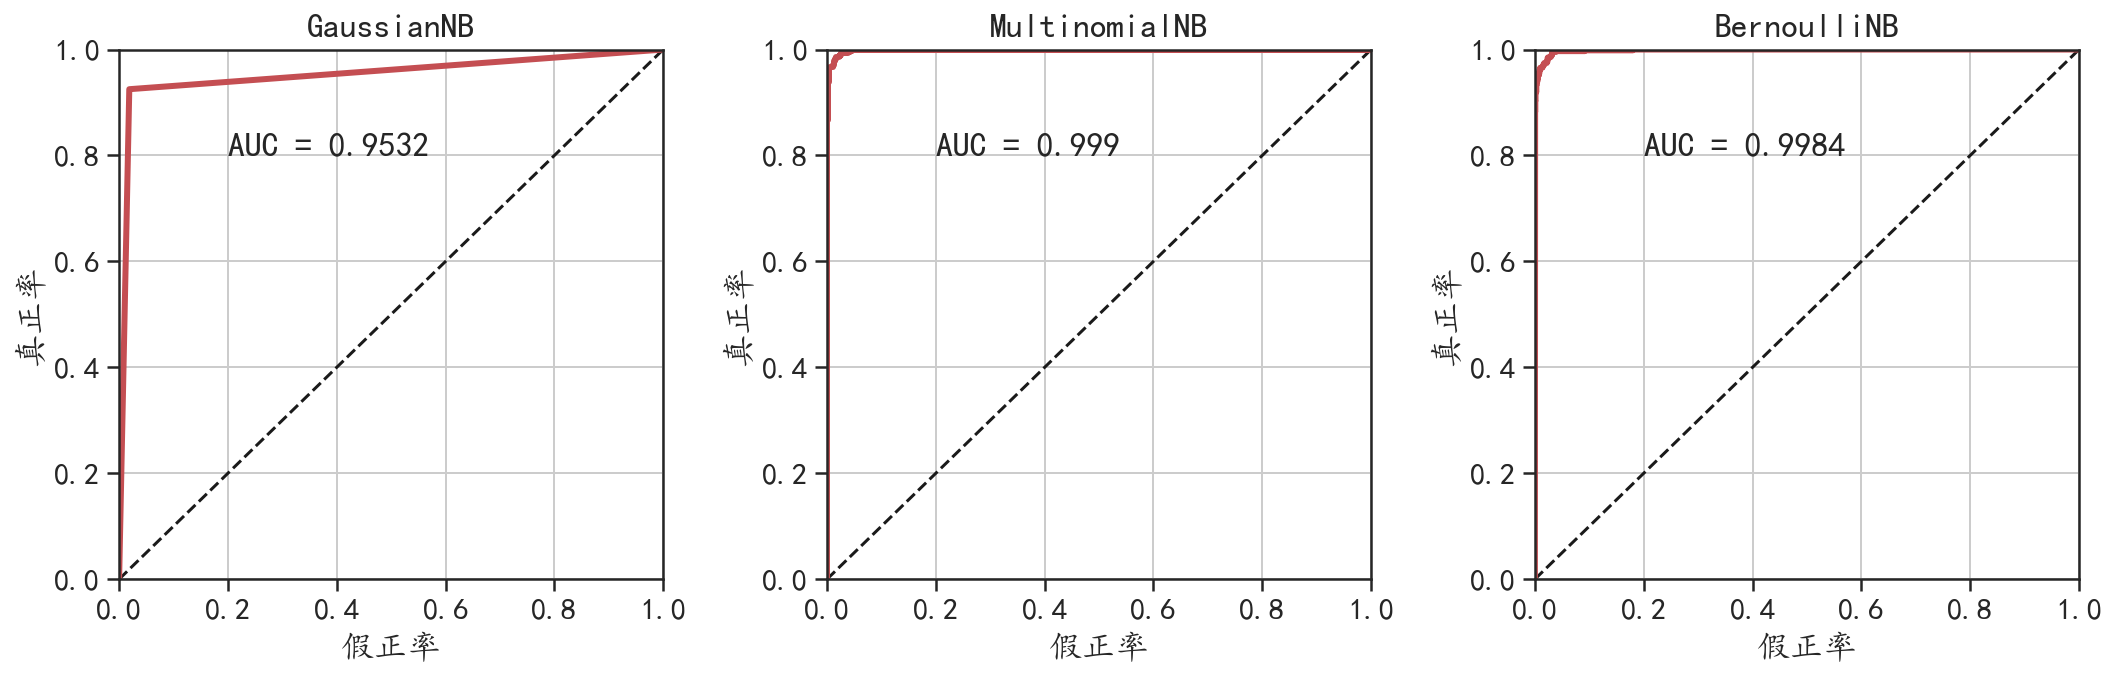

In [12]:
## 可视化三种算法的ROC曲线
model = [gnb,mnb,bnb]
modelname = ["GaussianNB","MultinomialNB","BernoulliNB"]
plt.figure(figsize=(15,5))
for ii,mod in enumerate(model):
    ## 对测试集进预测
    pre_score = mod.predict_proba(test_tfidf)
    ## 计算绘制ROC曲线的取值
    fpr_micro, tpr_micro, _ = roc_curve(y_test_lb.ravel(), pre_score.ravel())
    AUC = auc(fpr_micro, tpr_micro)  # AUC大小
    plt.subplot(1,3,ii+1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_micro, tpr_micro,"r",linewidth = 3)
    plt.xlabel("假正率")
    plt.ylabel("真正率")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()
    plt.title(modelname[ii])
    plt.text(0.2,0.8,"AUC = "+str(round(AUC,4)))
plt.tight_layout()
plt.show()

####  使用参数网格搜索，优化模型，寻找更好的参数

利用管道操作创造一个特征获取和分类的流程

In [13]:
## 对建模过程进行封装
bbc_nb = Pipeline([("vect", CountVectorizer(stop_words="english")),
                   ("tfidf", TfidfTransformer()),
                   ("mnb", MultinomialNB()),])
## 
## 定义网格搜索的参数
alpha = [0.001,0.01,0.1,0.5,1,10]
para_grid = {"vect__ngram_range": [(1, 1), (1, 2),(2,3)],
             "vect__max_features":[1000,2000,3000,5000],
             "tfidf__norm": ["l1","l2"],
             "mnb__alpha": alpha}
## 使用3折交叉验证进行搜索
gs_bbc_nb = GridSearchCV(bbc_nb,para_grid,cv=3,n_jobs=4)
gs_bbc_nb.fit(X_train,y_train)
## 得到最好的参数组合
gs_bbc_nb.best_params_

{'mnb__alpha': 0.1,
 'tfidf__norm': 'l2',
 'vect__max_features': 5000,
 'vect__ngram_range': (1, 2)}

In [14]:
## 将输出的所有搜索结果进行处理
results = pd.DataFrame(gs_bbc_nb.cv_results_)
## 输出感兴趣的结果
results2 = results[["mean_test_score","std_test_score","params"]]
results2 = results2.sort_values(["mean_test_score"],ascending = False)
results2.head()

mean_test_score  std_test_score  \
70         0.973025        0.007209   
94         0.971098        0.009825   
64         0.971098        0.004720   
88         0.970456        0.006358   
67         0.970456        0.007094   

                                                                                               params  
70  {'mnb__alpha': 0.1, 'tfidf__norm': 'l2', 'vect__max_features': 5000, 'vect__ngram_range': (1, 2)}  
94  {'mnb__alpha': 0.5, 'tfidf__norm': 'l2', 'vect__max_features': 5000, 'vect__ngram_range': (1, 2)}  
64  {'mnb__alpha': 0.1, 'tfidf__norm': 'l2', 'vect__max_features': 2000, 'vect__ngram_range': (1, 2)}  
88  {'mnb__alpha': 0.5, 'tfidf__norm': 'l2', 'vect__max_features': 2000, 'vect__ngram_range': (1, 2)}  
67  {'mnb__alpha': 0.1, 'tfidf__norm': 'l2', 'vect__max_features': 3000, 'vect__ngram_range': (1, 2)}

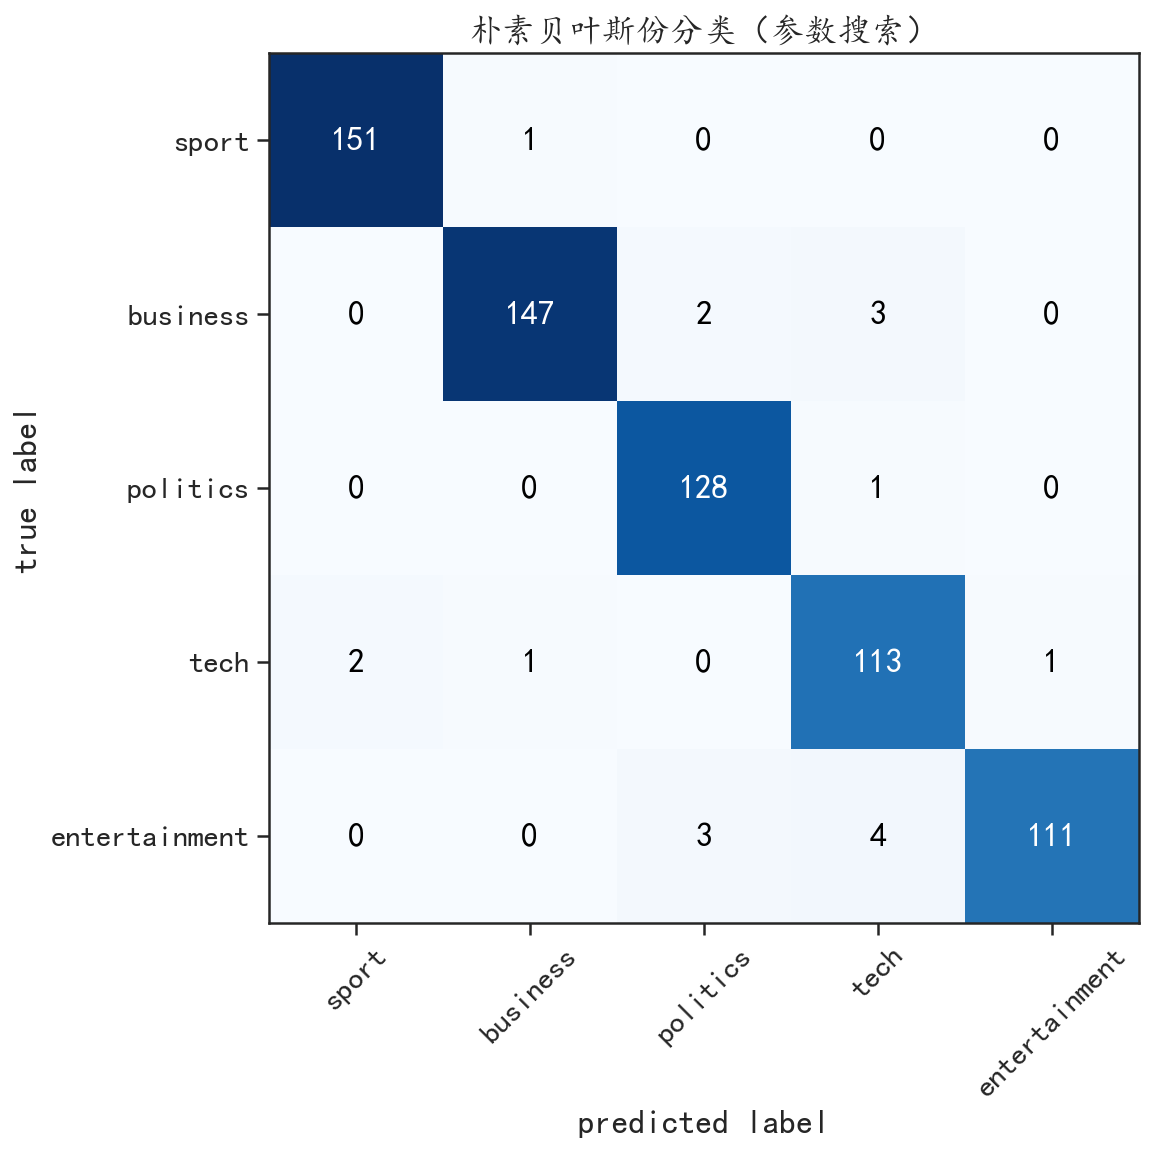

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       152
           1       0.99      0.97      0.98       152
           2       0.96      0.99      0.98       129
           3       0.93      0.97      0.95       117
           4       0.99      0.94      0.97       118

    accuracy                           0.97       668
   macro avg       0.97      0.97      0.97       668
weighted avg       0.97      0.97      0.97       668



In [15]:
## 使用最好效果的模型对测试集进预测
gs_pre = gs_bbc_nb.best_estimator_.predict(X_test)
## 可视化对测试集的混淆矩阵
lable_names = ["sport","business","politics","tech","entertainment"]
plot_confusion_matrix(confusion_matrix(y_test,gs_pre),
                      figsize=(10,8),class_names=lable_names)
plt.title("朴素贝叶斯份分类（参数搜索）")
plt.show()

print(classification_report(y_test,gs_pre))

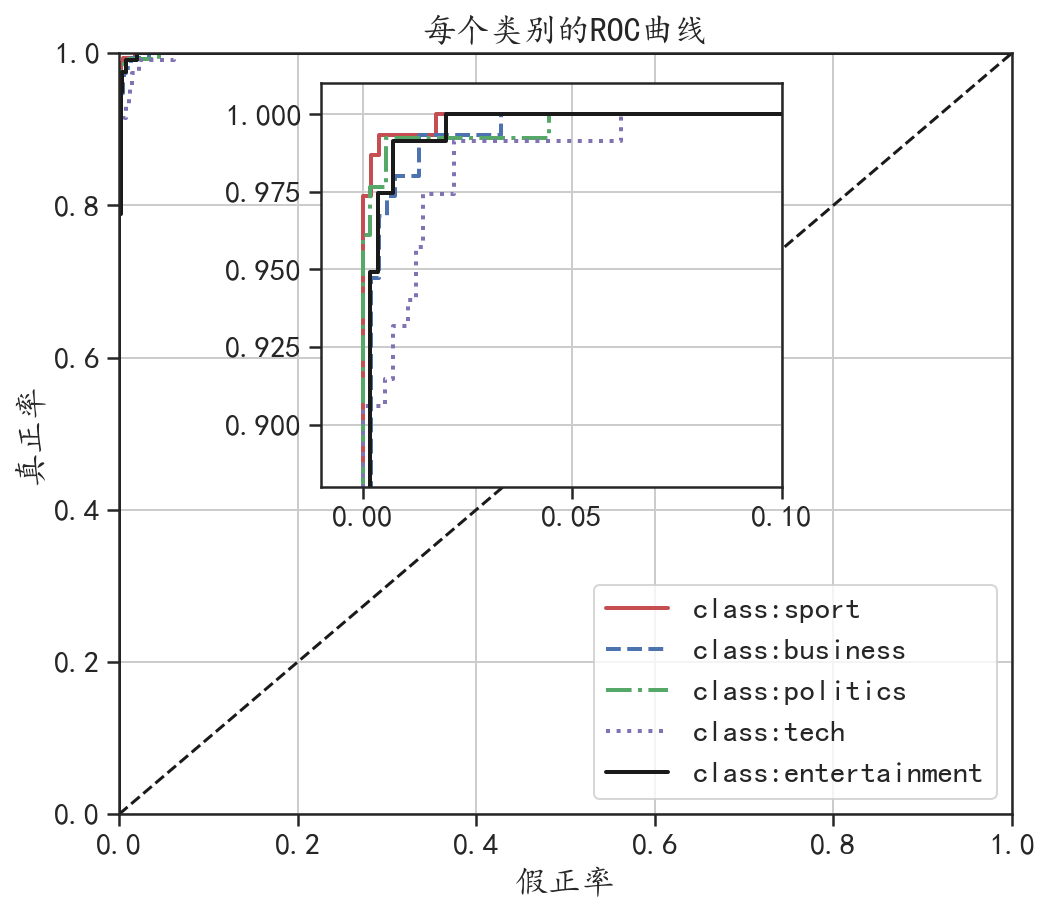

In [16]:
## 可视化每个类别的ROC曲线
lable_names = ["sport","business","politics","tech","entertainment"]
colors = ["r","b","g","m","k",]
linestyles =["-", "--", "-.", ":", "-"]
pre_score = gs_bbc_nb.best_estimator_.predict_proba(X_test)
fig  = plt.figure(figsize=(8,7))
for ii, color in zip(range(pre_score.shape[1]), colors):
    ## 计算绘制ROC曲线的取值
    fpr_ii, tpr_ii, _ = roc_curve(y_test_lb[:,ii], pre_score[:,ii])
    plt.plot(fpr_ii, tpr_ii,color = color,linewidth = 2,
             linestyle = linestyles[ii],
             label = "class:"+lable_names[ii])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("假正率")
plt.ylabel("真正率")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.title("每个类别的ROC曲线")
## 添加局部放大图
inset_ax = fig.add_axes([0.3, 0.45, 0.4, 0.4],facecolor="white")
for ii, color in zip(range(pre_score.shape[1]), colors):
    ## 计算绘制ROC曲线的取值
    fpr_ii, tpr_ii, _ = roc_curve(y_test_lb[:,ii], pre_score[:,ii])
    ## 局部放大图
    inset_ax.plot(fpr_ii, tpr_ii,color = color,linewidth = 2,
                  linestyle = linestyles[ii])
    inset_ax.set_xlim([-0.01,0.1])
    inset_ax.set_ylim([0.88,1.01])
    inset_ax.grid()
plt.show()

#### 9.3 贝叶斯网络数据分类

#### 9.3.1 自定义贝叶斯网络结构

In [10]:
## 读取预处理后的泰坦尼克数据
Taidf = pd.read_csv("data/chap9/预处理后泰坦尼号训练数据.csv")
Taidf = Taidf.drop("IsAlone",axis = 1) ## 删除一个不重要的变量
## 将年龄变量Age和Fare变量转化为分类变量
X = Taidf[["Age","Fare"]].values
Kbins  = KBinsDiscretizer(n_bins=[3,3],    #每个变量分别分为3份 
                          encode="ordinal",#分箱后的特征编码为整数
                          strategy = "kmeans")##每个变量执行k均值聚类过程的分箱策略
X_Kbins = Kbins.fit_transform(X)
X = Taidf[["Age","Fare"]] = np.int8(X_Kbins)
print(Taidf.head())

   Survived  Pclass  Name  Sex  Age  SibSp  Parch  Fare  Embarked
0         0       3     2    1    0      1      0     0         2
1         1       1     3    0    1      1      0     0         0
2         1       3     1    0    1      0      0     0         2
3         1       1     3    0    1      1      0     0         2
4         0       3     2    1    1      0      0     0         2


In [11]:
## 随机选择75%的数据作为训练集
trainnum = round(Taidf.shape[0] * 0.75)
np.random.seed(123)
index = np.random.permutation(Taidf.shape[0])[0:trainnum]
traindf = Taidf.iloc[index,:]
testdf = Taidf.drop(index,axis=0)
test_Survived = testdf["Survived"]
print("训练样本:",traindf.shape)
print("测试样本:",testdf.shape)

训练样本: (668, 9)
测试样本: (223, 9)


In [13]:
## 根据前面的决策树模型，自定义一个简单的贝叶斯网络
model = BayesianModel([("Fare","Survived"), ("Pclass","Survived"),
                       ("SibSp","Survived"),("Pclass","Fare"),
                       ("Name", "Pclass"),("Name","SibSp"),
                       ("Sex", "Pclass"),("Sex","Name")])
## 调用graphviz绘制贝叶斯网络的结构图
node_attr = dict(shape="ellipse",color = "lightblue2", style = "filled")
dot = Digraph(node_attr=node_attr)  # 定义一个图
dot.attr(rankdir="LR")   # 指定图的可视化放心为左右
edges = model.edges()    # 获取网络的边
for a,b in edges:
    dot.edge(a,b)
dot

NameError: name 'Digraph' is not defined

In [ ]:
## 模型使用的变量
usevarb = list(model.nodes())
model_traindf = traindf[usevarb]
model_testdf = testdf[usevarb]
model_testdf = model_testdf.drop(["Survived"],axis = 1)
## 根据数据拟合模型
model.fit(data = model_traindf,estimator=BayesianEstimator)

In [ ]:
## 使用模型对测试集进行预测
model_pre = model.predict(model_testdf)
model_acc = accuracy_score(test_Survived.values,model_pre)
print("贝叶斯网络在测试集上的精度为:",model_acc)

## 可以发现自定义的网络在测试集上的预测精度为0.6367

#### 9.3.2 搜索所有网络结构

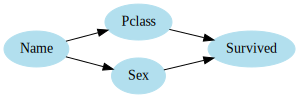

In [22]:
## 使用训练数据学习一个贝叶斯网络
## 如果变量较少可以使用ExhaustiveSearch搜索所有的贝叶斯网络
## 一般要求变量数小于5

## 根据数据中的3个变量利用ExhaustiveSearch进行网络搜索
model_estraindf = traindf[["Name","Sex","Pclass","Survived"]]
model_estestdf = testdf[["Name","Sex","Pclass"]]
bic = BicScore(model_estraindf)
# bic.score(BayesianModel([("Sex","Survived")]))
model_es = ExhaustiveSearch(model_estraindf, scoring_method=bic)
best_model = model_es.estimate()
# print("较好网络的边为:\n",best_model.edges())
## 调用graphviz绘制贝叶斯网络的结构图
node_attr = dict(shape="ellipse",color = "lightblue2", style = "filled")
dot = Digraph(node_attr=node_attr)  # 定义一个图
dot.attr(rankdir="LR")   # 指定图的可视化放心为左右
edges = best_model.edges()    # 获取网络的边
for a,b in edges:
    dot.edge(a,b)
dot

In [23]:
## 输出不同的网络对应的bic值,评分越高，网络越合理
bicscore = []
nbgraph = []
for score, dag in reversed(model_es.all_scores()):
    bicscore.append(score)
    nbgraph.append(dag.edges())
## 组成数据表格
model_esdf = pd.DataFrame(data= {"bicscore":bicscore,"nbgraph":nbgraph})
model_esdf.head()
## 可以发现前三个网络的评分是一样的

bicscore  \
0 -1789.665184   
1 -1789.665184   
2 -1789.665184   
3 -1801.414656   
4 -1801.414656   

                                                              nbgraph  
0  ((Name, Sex), (Sex, Survived), (Pclass, Survived), (Pclass, Name))  
1  ((Name, Pclass), (Pclass, Survived), (Sex, Survived), (Sex, Name))  
2  ((Name, Pclass), (Name, Sex), (Pclass, Survived), (Sex, Survived))  
3                  ((Name, Sex), (Sex, Survived), (Pclass, Survived))  
4                  ((Pclass, Survived), (Sex, Survived), (Sex, Name))

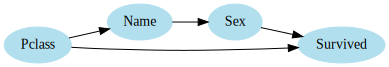

In [24]:
## 可视化前三个网络
## 调用graphviz绘制贝叶斯网络的结构图
node_attr = dict(shape="ellipse",color = "lightblue2", style = "filled")
## 可视化第一个网络
dot = Digraph(node_attr=node_attr)  
dot.attr(rankdir="LR")   
edges = nbgraph[0]   
for a,b in edges:
    dot.edge(a,b)
dot

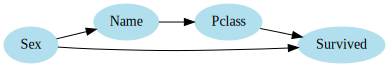

In [25]:
## 可视化第二个网络
dot = Digraph(node_attr=node_attr) 
dot.attr(rankdir="LR")  
edges = nbgraph[1]   
for a,b in edges:
    dot.edge(a,b)
dot

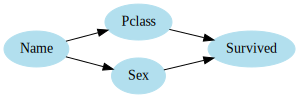

In [26]:
## 可视化第三个网络
dot = Digraph(node_attr=node_attr)  
dot.attr(rankdir="LR")  
edges = nbgraph[2]    
for a,b in edges:
    dot.edge(a,b)
dot

In [27]:
## 使用最好的网络建立模型并预测测试集的精度
best_model = BayesianModel(best_model.edges())
best_model.fit(data = model_estraindf,estimator=BayesianEstimator)
model_pre = best_model.predict(model_estestdf)
model_acc = accuracy_score(test_Survived.values,model_pre)
print("贝叶斯网络在测试集上的精度为:",model_acc)


100%|██████████| 13/13 [00:00<00:00, 3650.64it/s]

贝叶斯网络在测试集上的精度为: 0.7443946188340808


#### 9.3.3 启发式搜索网络结构


  0%|          | 13/1000000 [00:01<22:12:18, 12.51it/s]


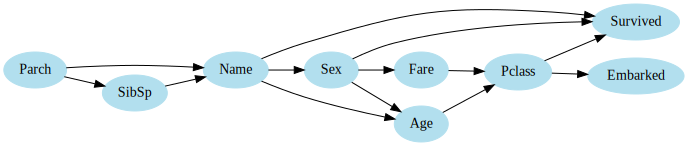

In [28]:
## 启发式搜索网络结构
bic = BicScore(traindf)
# bic.score(BayesianModel([("Sex","Survived")]))
hc = HillClimbSearch(traindf, scoring_method=bic)
best_model = hc.estimate()
# print("启发式搜索到的网络结构为:\n",best_model.edges())
## 调用graphviz绘制贝叶斯网络的结构图
node_attr = dict(shape="ellipse",color = "lightblue2", style = "filled")
dot = Digraph(node_attr=node_attr)  # 定义一个图
dot.attr(rankdir="LR")   # 指定图的可视化放心为左右
edges = best_model.edges()    # 获取网络的边
for a,b in edges:
    dot.edge(a,b)
dot

In [29]:
## 使用最好的网络建立模型并预测测试集的精度
best_model = BayesianModel(best_model.edges())
best_model.fit(data = traindf,estimator=BayesianEstimator)
model_pre = best_model.predict(testdf.drop("Survived",axis = 1))
model_acc = accuracy_score(test_Survived.values,model_pre)
print("贝叶斯网络在测试集上的精度为:",model_acc)

## 可以发现虽然获得的网路更加的复杂了，但是网络的预测精度并没有显著的提升

100%|██████████| 113/113 [00:01<00:00, 102.07it/s]


贝叶斯网络在测试集上的精度为: 0.7668161434977578


### 9.4 K近邻算法


#### 9.4.1 K近邻数据分类


##### 数据准备

In [30]:
## 读取信用卡数据
credit = pd.read_excel("data/chap9/default of credit card clients.xls")
credit = credit.drop(labels = ["ID"],axis = 1)  # 删除变量ID
credit.head(5)

X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  ...    X15    X16    X17  \
0   20000   2   2   1  24   2   2  -1  -1   -2  ...      0      0      0   
1  120000   2   2   2  26  -1   2   0   0    0  ...   3272   3455   3261   
2   90000   2   2   2  34   0   0   0   0    0  ...  14331  14948  15549   
3   50000   2   2   1  37   0   0   0   0    0  ...  28314  28959  29547   
4   50000   1   2   1  57  -1   0  -1   0    0  ...  20940  19146  19131   

    X18    X19    X20   X21   X22   X23  Y  
0     0    689      0     0     0     0  1  
1     0   1000   1000  1000     0  2000  1  
2  1518   1500   1000  1000  1000  5000  0  
3  2000   2019   1200  1100  1069  1000  0  
4  2000  36681  10000  9000   689   679  0  

[5 rows x 24 columns]

In [31]:
## 查看类别标签Y的比例
credit["Y"].value_counts()   ## 可以发现取值为1的数据大约是取值为0的1/4

0    23364
1     6636
Name: Y, dtype: int64

In [32]:
## 数据清洗和预处理操作

## 查看数据是否有异常值
print(credit.isna().apply(sum,axis=0))


X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
Y      0
dtype: int64


X_train.shape: (21000, 23)
X_test.shape: (9000, 23)


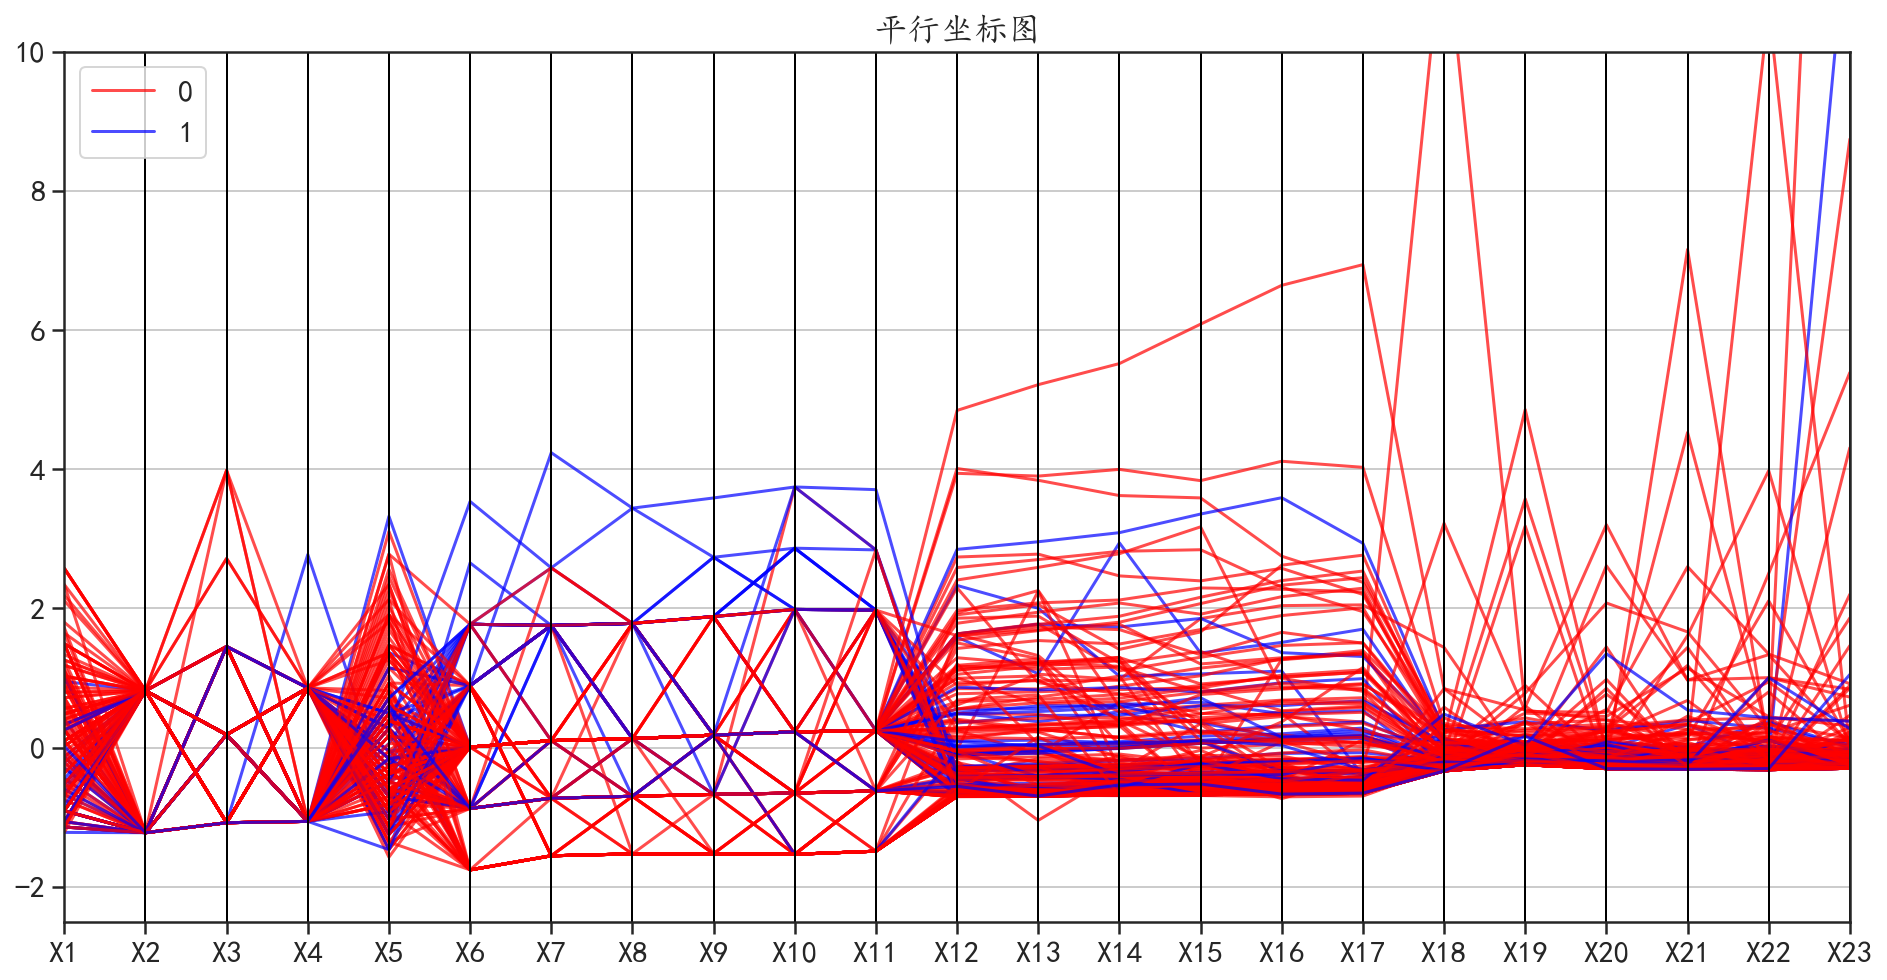

In [33]:
## 数据清洗和预处理操作

## 将数据切分为训练集和测试集，训练集70%，测试集30%
X_train,X_test,y_train,y_test = train_test_split(
    credit.iloc[:,0:23],credit["Y"],test_size = 0.3, random_state=0)
print("X_train.shape:",X_train.shape)
print("X_test.shape:",X_test.shape)


## 对数据进标准化预处理
std =  StandardScaler()
X_train_s = std.fit_transform(X_train)
X_test_s = std.transform(X_test)

## 对标准化后的数据特征进行可视化

## 挑选出部分样本使用平行坐标图对数据进可视化
plotnum = 200
plotdata = pd.DataFrame(data = X_train_s[0:plotnum ,:],columns=X_train.columns)
plotdata["Y"] = y_train.values[0:plotnum ]
plt.figure(figsize=(16,8))
parallel_coordinates(plotdata, class_column = "Y",
                     color = ["red","blue"],alpha = 0.7)
plt.title("平行坐标图")
plt.ylim([-2.5,10])
plt.legend(loc = 2)
plt.show()


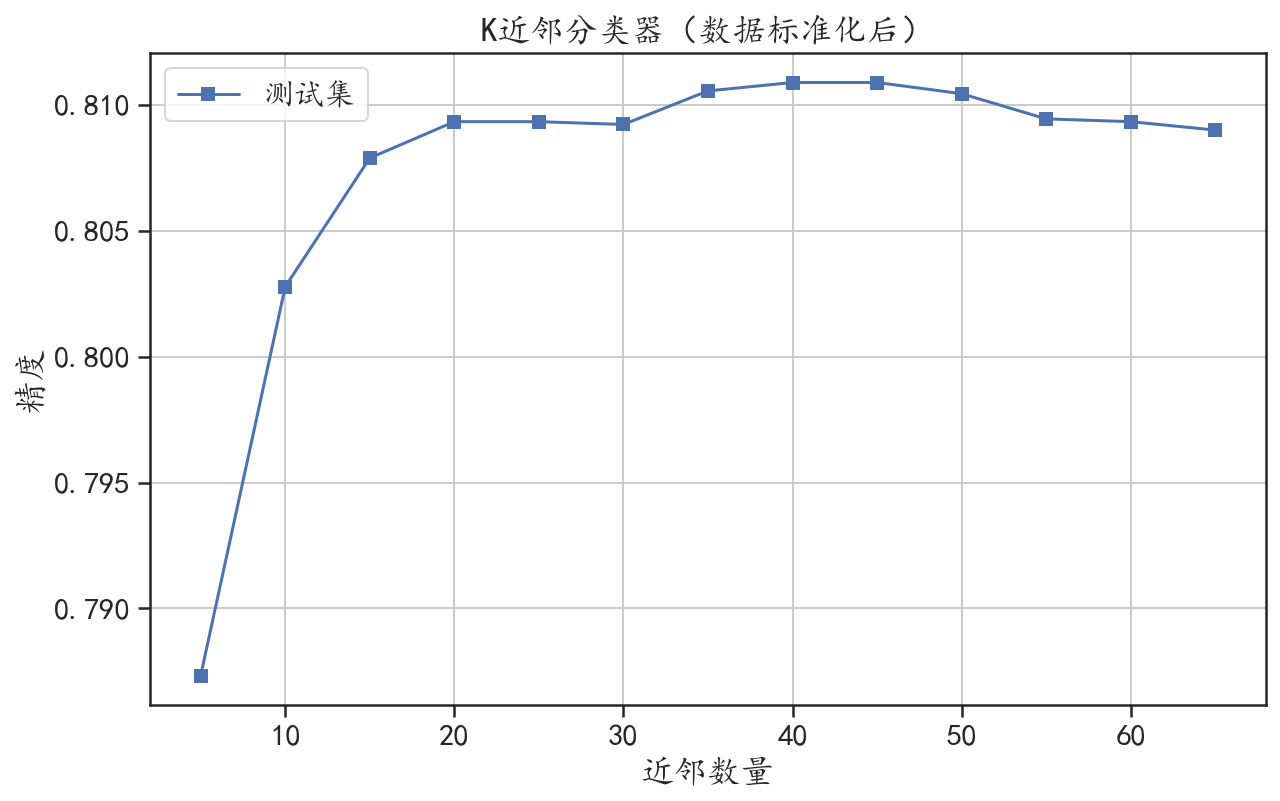

In [34]:
## 对标准化后的数据训练K近邻分类
n_neighbors = np.arange(5,70,5)
test_acc = []
for n_neighbor in n_neighbors:
    knncla = KNeighborsClassifier(n_neighbors = n_neighbor,
                                  weights = "distance",n_jobs = 4)
    knncla.fit(X_train_s,y_train.values) # 标准化后数据训练模型
    ## 计算测试集上的预测精度
    test_acc.append(knncla.score(X_test_s,y_test.values))

    
## 可视化在测试集上的预测精度
plt.figure(figsize=(10,6))
plt.plot(n_neighbors,test_acc,"b-s",label = "测试集")
plt.legend()
plt.grid()
plt.xlabel("近邻数量")
plt.ylabel("精度")
plt.title("K近邻分类器（数据标准化后）")
plt.show()

####  无监督的数据降维提取特征

In [35]:
## 利用无监督的数据降维方法，获取对数据进降维后的特征
## 这样作的目的是帮助使用者更好的理解K近邻分类的特点

## 使用SparsePCA算法对数据进行降维，以便获取主要的特征变换
pca = SparsePCA(n_components=2,alpha =0.05,
                random_state = 10,n_jobs = 4)
X_train_pca = pca.fit_transform(X_train_s)
X_test_pca = pca.fit_transform(X_test_s)
print("X_train_pca.shape",X_train_pca.shape)
print("X_test_pca.shape",X_test_pca.shape)


X_train_pca.shape (21000, 2)
X_test_pca.shape (9000, 2)


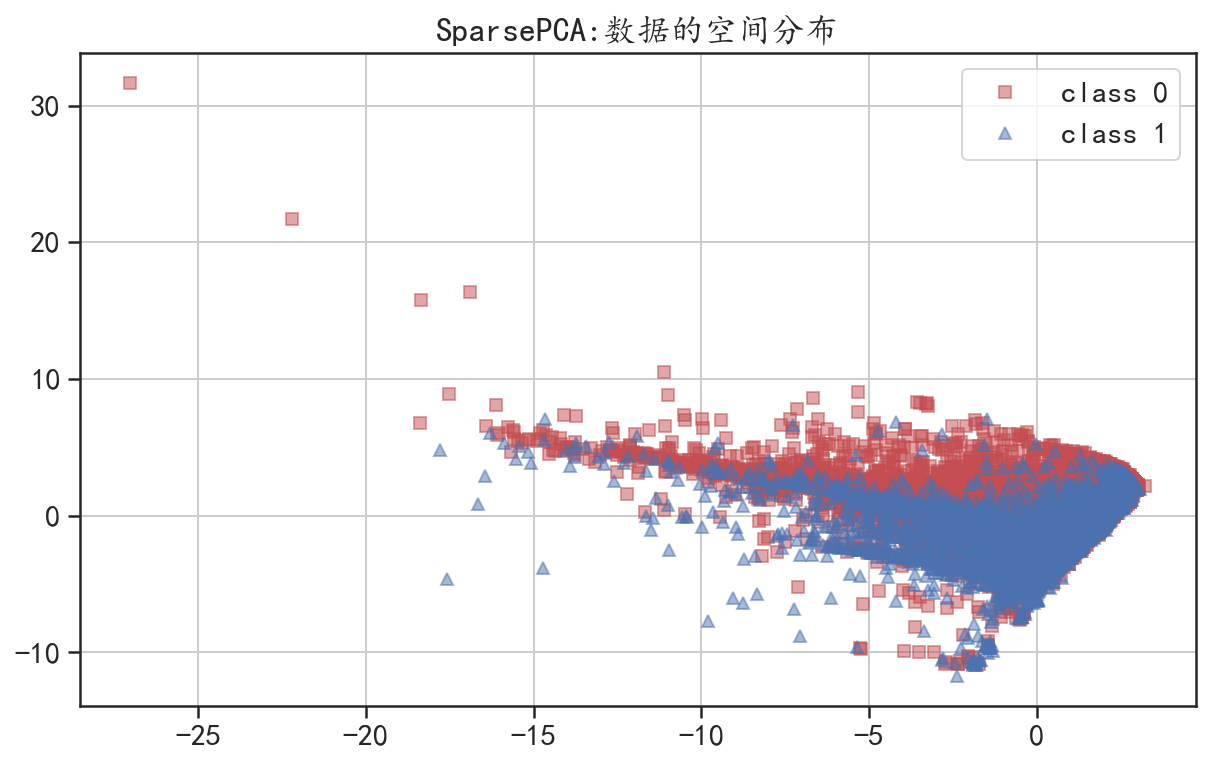

In [36]:
## 使用散点图可视化训练数据在空间中的分布
x = X_train_pca[:,0]
y = X_train_pca[:,1]
label = y_train.values
plt.figure(figsize=(10,6))
plt.plot(x[label==0],y[label==0],"rs",label = "class 0",alpha=0.5)
plt.plot(x[label==1],y[label==1],"b^",label = "class 1",alpha=0.5)
plt.legend()
plt.grid()
plt.title("SparsePCA:数据的空间分布")
plt.show()

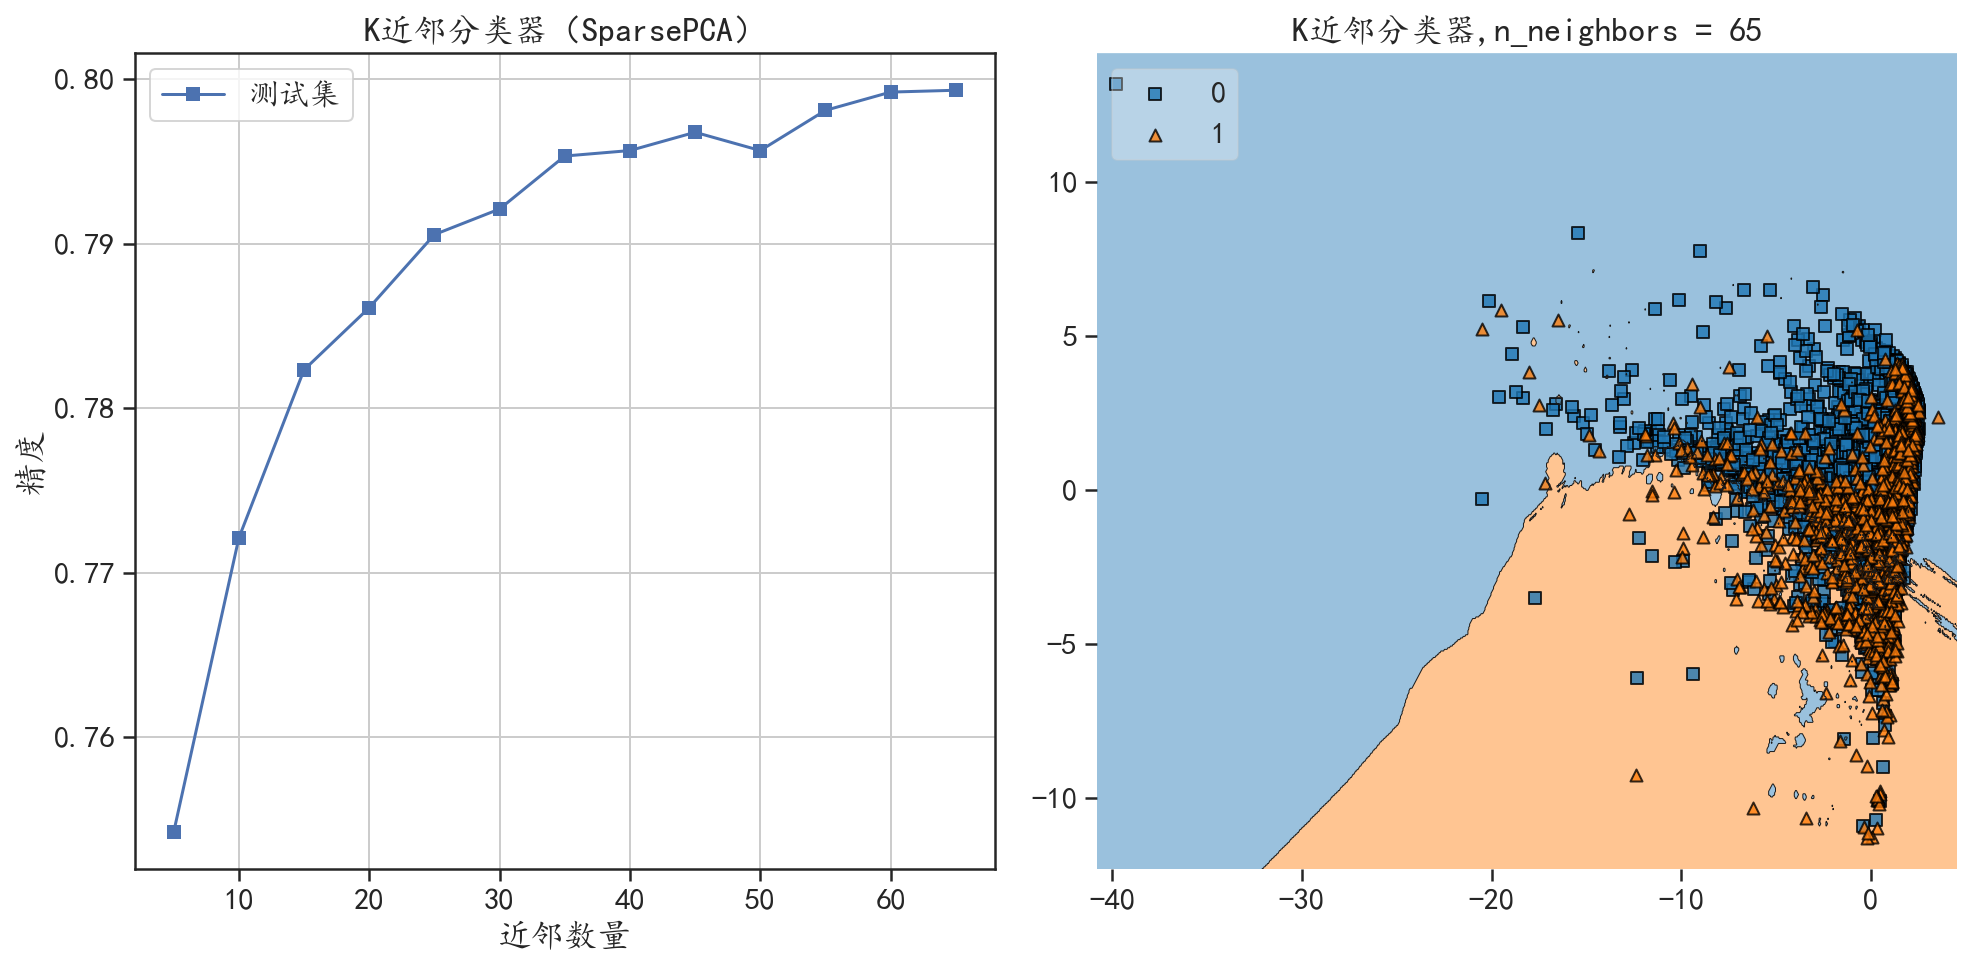

In [37]:
## 对SPCA的数据训练K近邻分类器
n_neighbors = np.arange(5,70,5)
test_acc = []
for n_neighbor in n_neighbors:
    knncla = KNeighborsClassifier(n_neighbors = n_neighbor,
                                  weights = "distance",n_jobs = 4)
    knncla.fit(X_train_pca,y_train.values) # 过采样数据训练模型
    ## 计算测试集上的误差
    test_acc.append(knncla.score(X_test_pca,y_test.values))

    
## 结果可视化
plt.figure(figsize=(14,7))
## 可视化在测试集上的预测精度
plt.subplot(1,2,1)
plt.plot(n_neighbors,test_acc,"b-s",label = "测试集")
plt.legend()
plt.grid()
plt.xlabel("近邻数量")
plt.ylabel("精度")
plt.title("K近邻分类器（SparsePCA）")

## 可视化K近邻分类器的决策面
plt.subplot(1,2,2)
plot_decision_regions(X_test_pca,y_test.values, clf=knncla,legend=2)
plt.title("K近邻分类器,n_neighbors = "+str(knncla.n_neighbors))
plt.tight_layout()
plt.show()

In [38]:
## 使用TSNE算法对数据进行降维，以便获取主要的特征变换
tsne = TSNE(n_components=2,random_state = 10,n_jobs = 4)
X_train_tsne = tsne.fit_transform(X_train_s)
X_test_tsne = tsne.fit_transform(X_test_s)
print("X_train_tsne.shape",X_train_tsne.shape)
print("X_test_tsne.shape",X_test_tsne.shape)

X_train_tsne.shape (21000, 2)
X_test_tsne.shape (9000, 2)


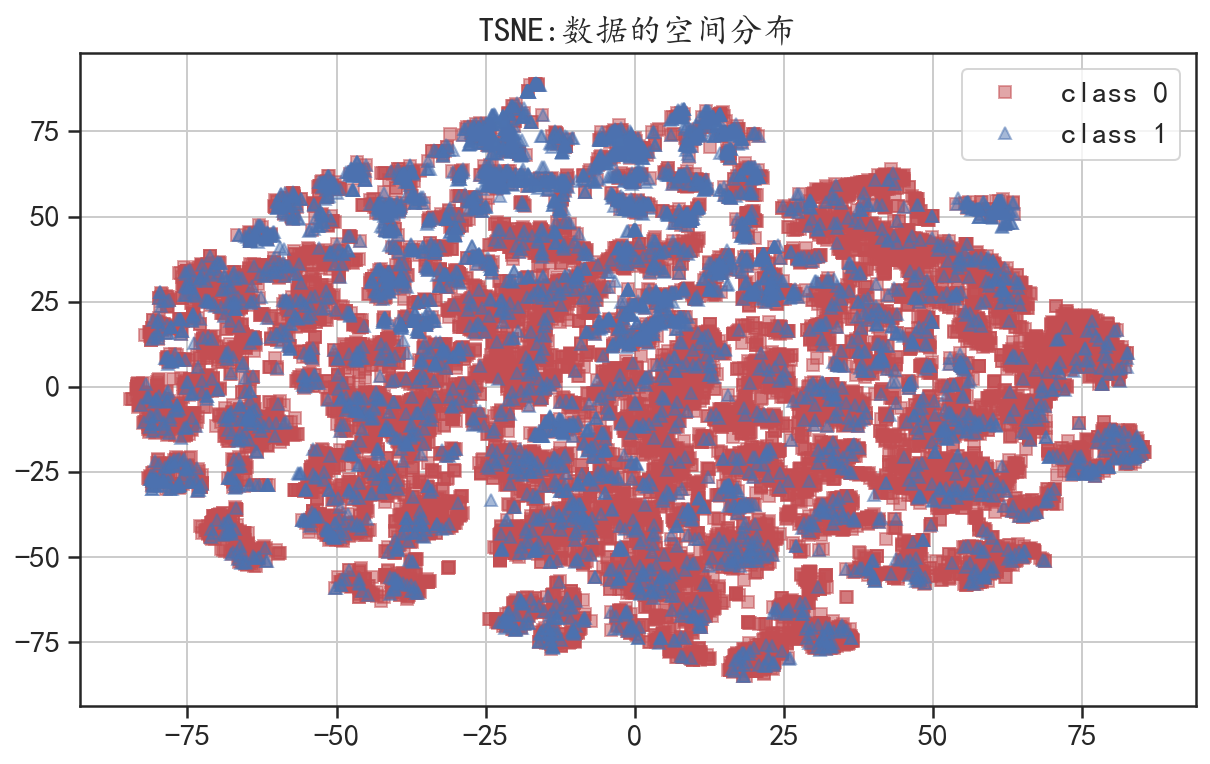

In [39]:
##  获取在训练集和测试集上的降维后特征

## 使用散点图可视化训练数据在空间中的分布
x = X_train_tsne[:,0]
y = X_train_tsne[:,1]
label = y_train.values
plt.figure(figsize=(10,6))
plt.plot(x[label==0],y[label==0],"rs",label = "class 0",alpha=0.5)
plt.plot(x[label==1],y[label==1],"b^",label = "class 1",alpha=0.5)
plt.legend()
plt.grid()
plt.title("TSNE:数据的空间分布")
plt.show()

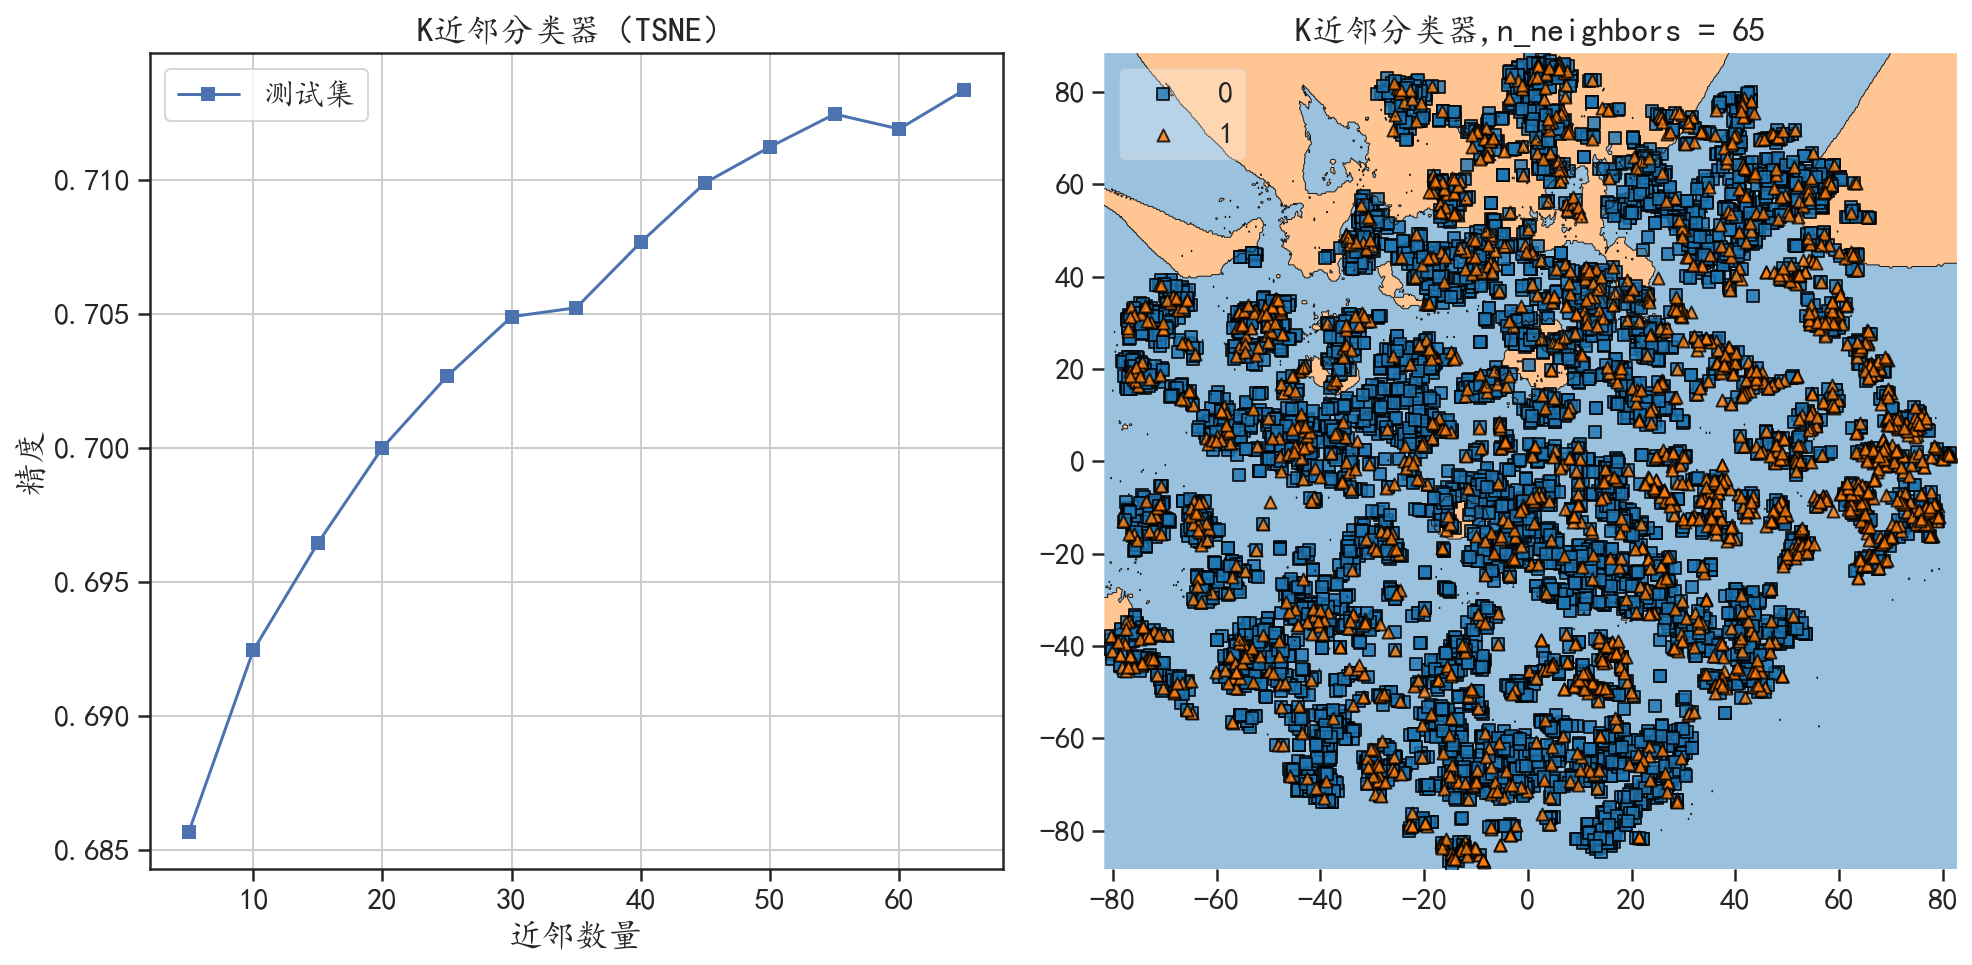

In [40]:
## 对TSNE的数据训练K近邻分类器
n_neighbors = np.arange(5,70,5)
test_acc = []
for n_neighbor in n_neighbors:
    knncla = KNeighborsClassifier(n_neighbors = n_neighbor,
                                  weights = "distance",n_jobs = 4)
    knncla.fit(X_train_tsne,y_train.values) # 过采样数据训练模型
    ## 计算测试集上的误差
    test_acc.append(knncla.score(X_test_tsne,y_test.values))

    
## 结果可视化
plt.figure(figsize=(14,7))
## 可视化在测试集上的预测精度
plt.subplot(1,2,1)
plt.plot(n_neighbors,test_acc,"b-s",label = "测试集")
plt.legend()
plt.grid()
plt.xlabel("近邻数量")
plt.ylabel("精度")
plt.title("K近邻分类器（TSNE）")

## 可视化K近邻分类器的决策面
plt.subplot(1,2,2)
plot_decision_regions(X_test_tsne,y_test.values, clf=knncla,legend=2)
plt.title("K近邻分类器,n_neighbors = "+str(knncla.n_neighbors))
plt.tight_layout()
plt.show()

####  有监督的数据降维提取特征

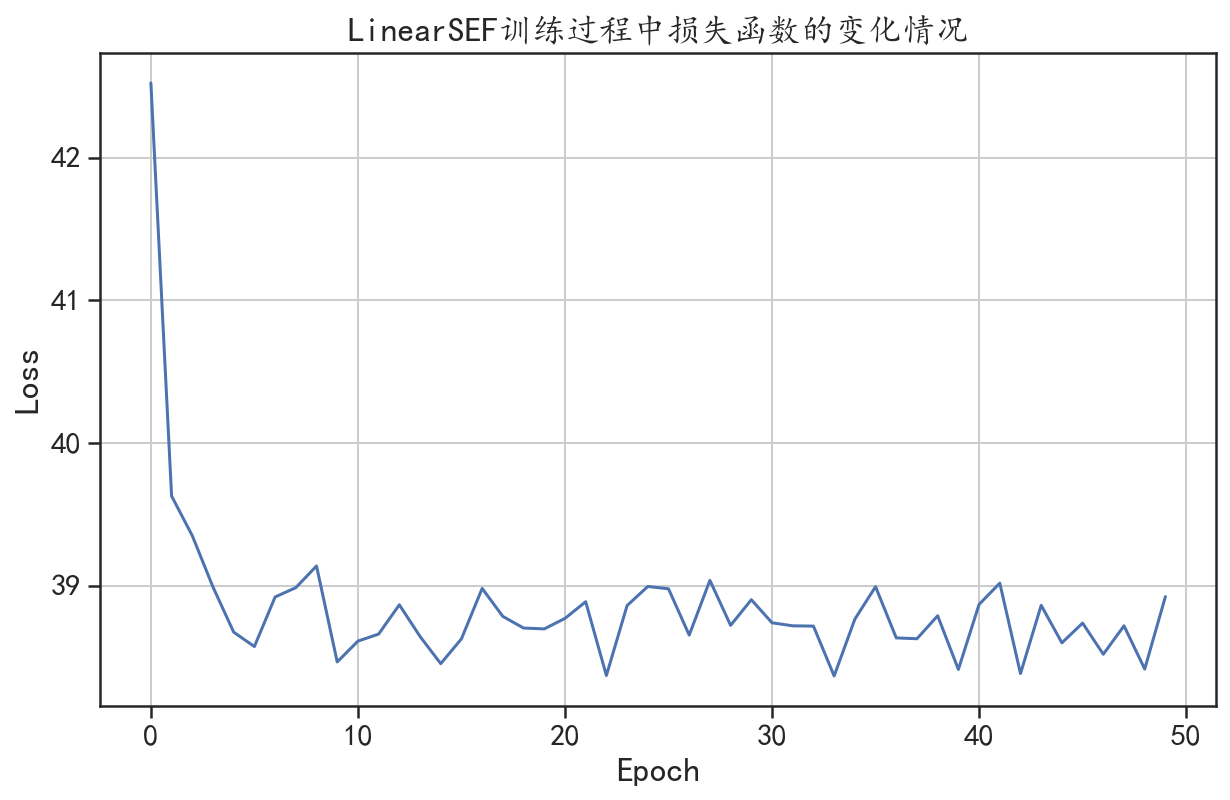

In [41]:
## 利用有监督的数据降维方法，获取对数据进降维后的特征

## 这样作的目的是帮助使用者更好的理解K近邻分类的特点
## 使用LinearSEF降维，输出2个特征
linear_sef = sef_dr.LinearSEF(input_dimensionality=X_train_s.shape[1],
                              output_dimensionality=2) 
## 有监督降维算法训练50个epoch
loss = linear_sef.fit(data=X_train_s, target_labels=y_train.values,
                      target="supervised", epochs=50, regularizer_weight=0.01,
                      learning_rate=0.01, batch_size=256)

## 可视化出损失函数的变化情况
plt.figure(figsize=(10,6))
plt.plot(np.arange(loss.shape[0]), loss)
plt.grid()
plt.title("LinearSEF训练过程中损失函数的变化情况")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

X_train_sef.shape (21000, 2)
X_test_sef.shape (9000, 2)


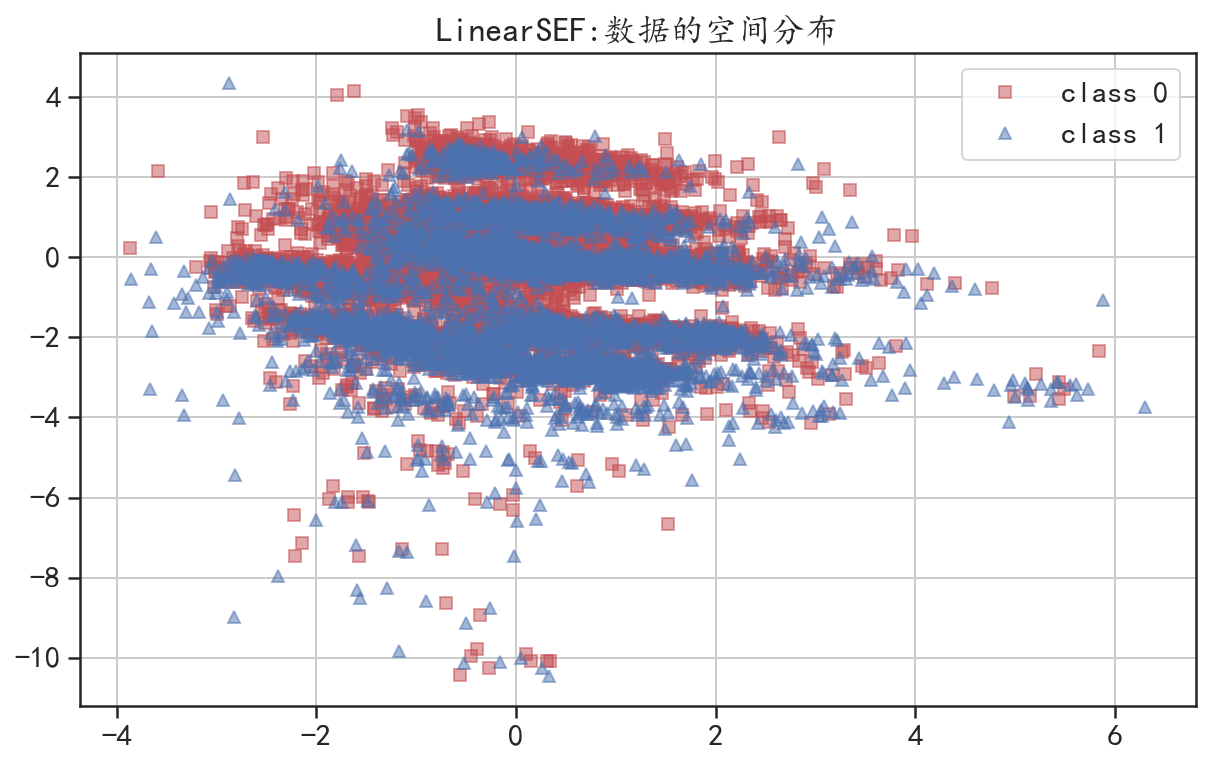

In [42]:
##  获取在训练集和测试集上的降维后特征
X_train_sef = linear_sef.transform(X_train_s)
X_test_sef = linear_sef.transform(X_test_s)
print("X_train_sef.shape",X_train_sef.shape)
print("X_test_sef.shape",X_test_sef.shape)
## 使用散点图可视化训练数据在空间中的分布
x = X_train_sef[:,0]
y = X_train_sef[:,1]
label = y_train.values
plt.figure(figsize=(10,6))
plt.plot(x[label==0],y[label==0],"rs",label = "class 0",alpha=0.5)
plt.plot(x[label==1],y[label==1],"b^",label = "class 1",alpha=0.5)
plt.legend()
plt.grid()
plt.title("LinearSEF:数据的空间分布")
plt.show()

In [43]:
# ## 使用散点图可视化训练数据在空间中的分布
# x = X_test_sef[:,0]
# y = X_test_sef[:,1]
# label = y_test.values
# plt.figure(figsize=(10,6))
# plt.plot(x[label==0],y[label==0],"rs",label = "class 0",alpha=0.5)
# plt.plot(x[label==1],y[label==1],"b^",label = "class 1",alpha=0.5)
# plt.legend()
# plt.grid()
# plt.title("数据的空间分布")
# plt.show()

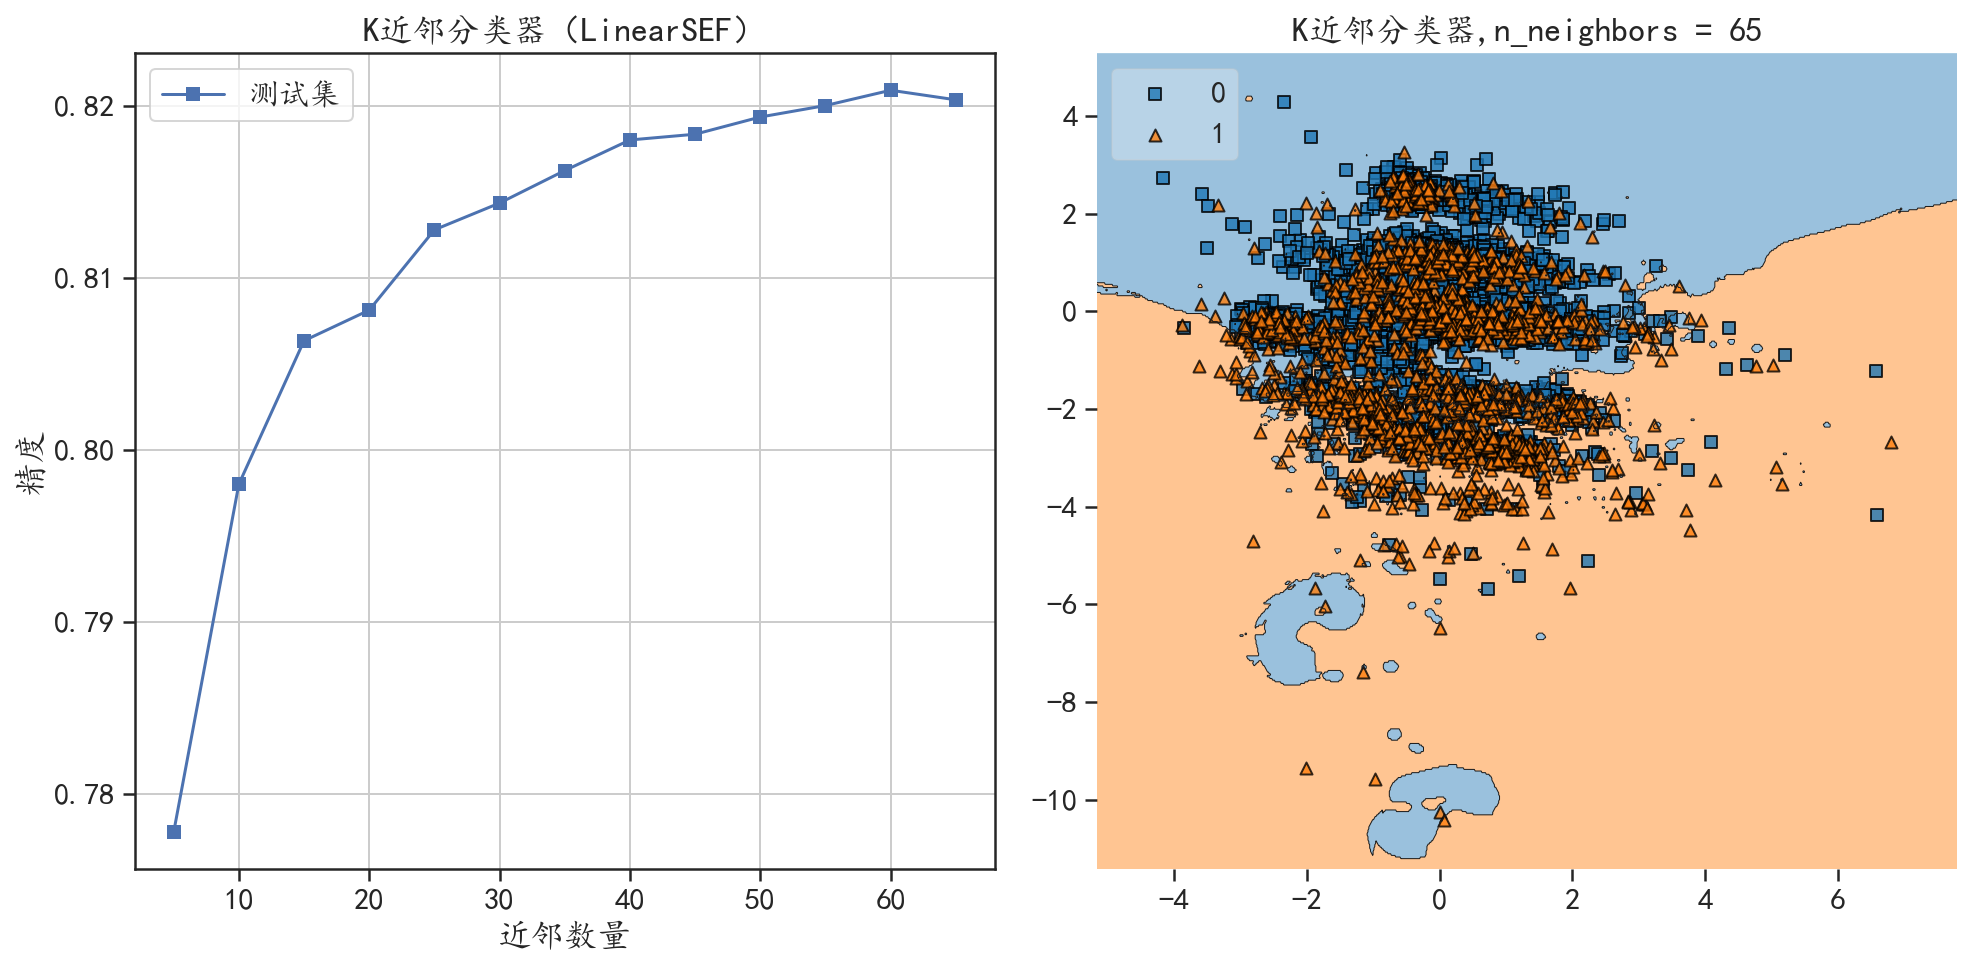

In [44]:
## 使用K近邻算法，分析不同的K值对测试集精度的影响
n_neighbors = np.arange(5,70,5)
test_acc = []
for n_neighbor in n_neighbors:
    knncla = KNeighborsClassifier(n_neighbors = n_neighbor,
                                  weights = "distance",n_jobs = 4)
    knncla.fit(X_train_sef,y_train.values) # 训练模型
    ## 计算测试集上的误差
    test_acc.append(knncla.score(X_test_sef,y_test.values))

## 结果可视化
plt.figure(figsize=(14,7))
## 可视化在测试集上的预测精度
plt.subplot(1,2,1)
plt.plot(n_neighbors,test_acc,"b-s",label = "测试集")
plt.legend()
plt.grid()
plt.xlabel("近邻数量")
plt.ylabel("精度")
plt.title("K近邻分类器（LinearSEF）")

## 可视化K近邻在数据集上的分类器决策面
plt.subplot(1,2,2)
plot_decision_regions(X_test_sef,y_test.values, clf=knncla,legend=2)
plt.title("K近邻分类器,n_neighbors = "+str(knncla.n_neighbors))
plt.tight_layout()
plt.show()

In [45]:
## 使用LDA降维，并进行据诶分析可视化
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train.values)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
print("X_train_lda.shape",X_train_lda.shape)
print("X_test_lda.shape",X_test_lda.shape)

X_train_lda.shape (21000, 1)
X_test_lda.shape (9000, 1)


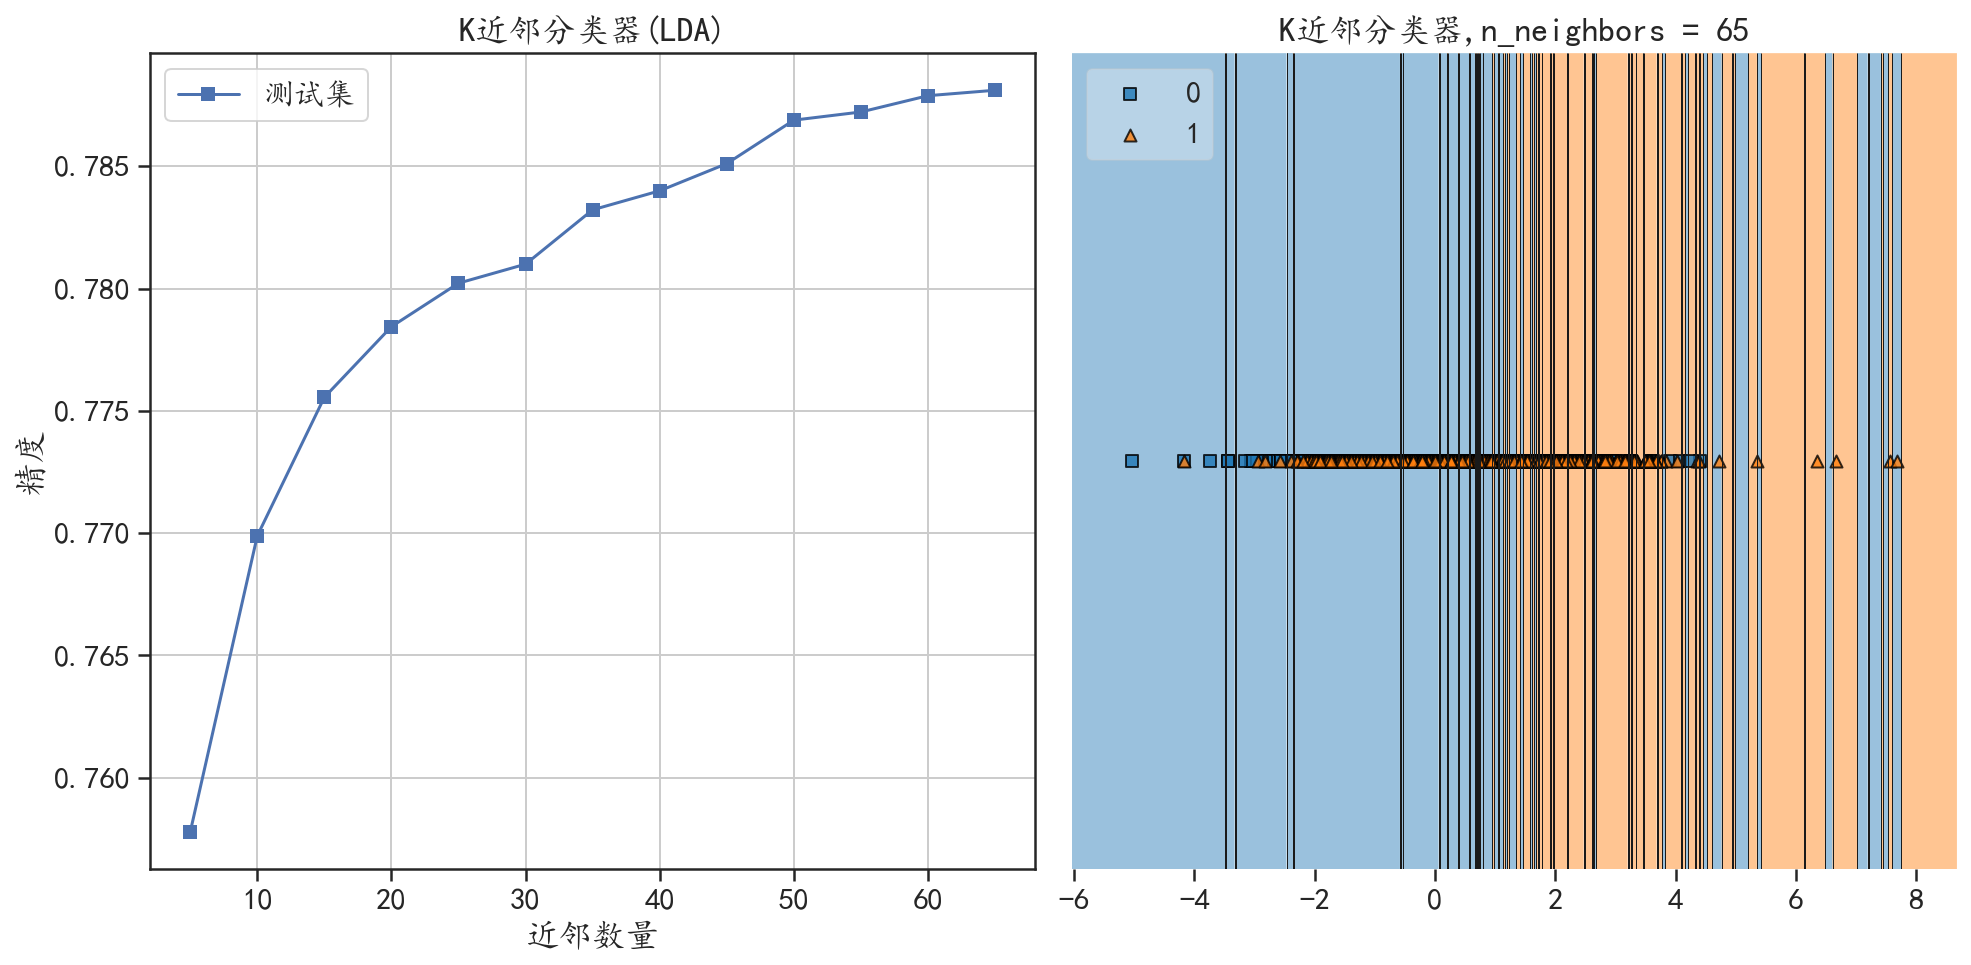

In [46]:
## 使用K近邻算法，分析不同的K值对测试集精度的影响
n_neighbors = np.arange(5,70,5)
test_acc = []
for n_neighbor in n_neighbors:
    knncla = KNeighborsClassifier(n_neighbors = n_neighbor,
                                  weights = "distance",n_jobs = 4)
    knncla.fit(X_train_lda,y_train.values) # 训练模型
    ## 计算测试集上的误差
    test_acc.append(knncla.score(X_test_lda,y_test.values))

## 结果可视化
plt.figure(figsize=(14,7))
## 可视化在测试集上的预测精度
plt.subplot(1,2,1)
plt.plot(n_neighbors,test_acc,"b-s",label = "测试集")
plt.legend()
plt.grid()
plt.xlabel("近邻数量")
plt.ylabel("精度")
plt.title("K近邻分类器(LDA)")

## 可视化K近邻在数据集上的分类器决策面
plt.subplot(1,2,2)
plot_decision_regions(X_test_lda,y_test.values, clf=knncla,legend=2)
plt.title("K近邻分类器,n_neighbors = "+str(knncla.n_neighbors))
plt.tight_layout()
plt.show()

#### 使用更高维度的特征进行聚类分析

X_train_sef.shape (21000, 5)
X_test_sef.shape (9000, 5)


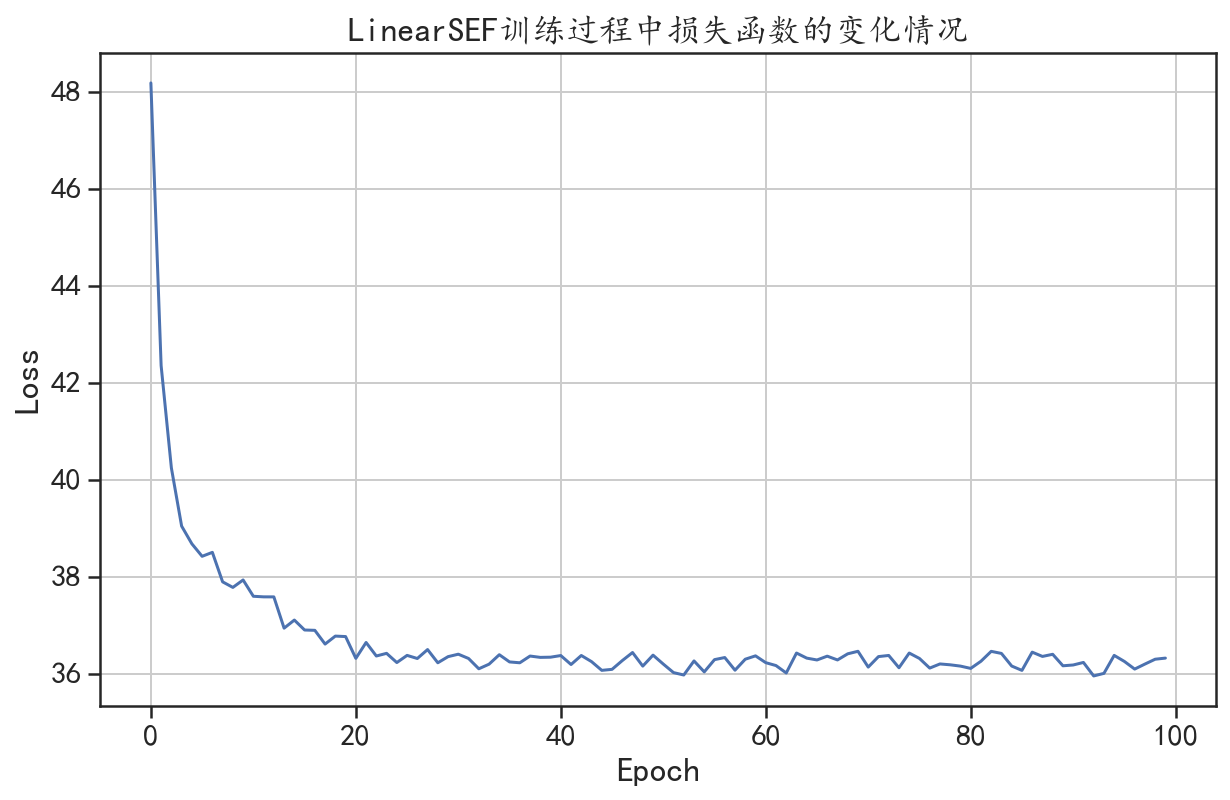

In [47]:
## 使用LinearSEF降维，输出5个特征
linear_sef = sef_dr.LinearSEF(input_dimensionality=X_train_s.shape[1],
                              output_dimensionality=5) 
## 有监督降维算法训练50个epoch
loss = linear_sef.fit(data=X_train_s, target_labels=y_train.values,
                      target="supervised", epochs=100, regularizer_weight=0.01,
                      learning_rate=0.001, batch_size=256)

##  获取在训练集和测试集上的降维后特征
X_train_sef = linear_sef.transform(X_train_s)
X_test_sef = linear_sef.transform(X_test_s)
print("X_train_sef.shape",X_train_sef.shape)
print("X_test_sef.shape",X_test_sef.shape)

## 可视化出损失函数的变化情况
plt.figure(figsize=(10,6))
plt.plot(np.arange(loss.shape[0]), loss)
plt.grid()
plt.title("LinearSEF训练过程中损失函数的变化情况")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

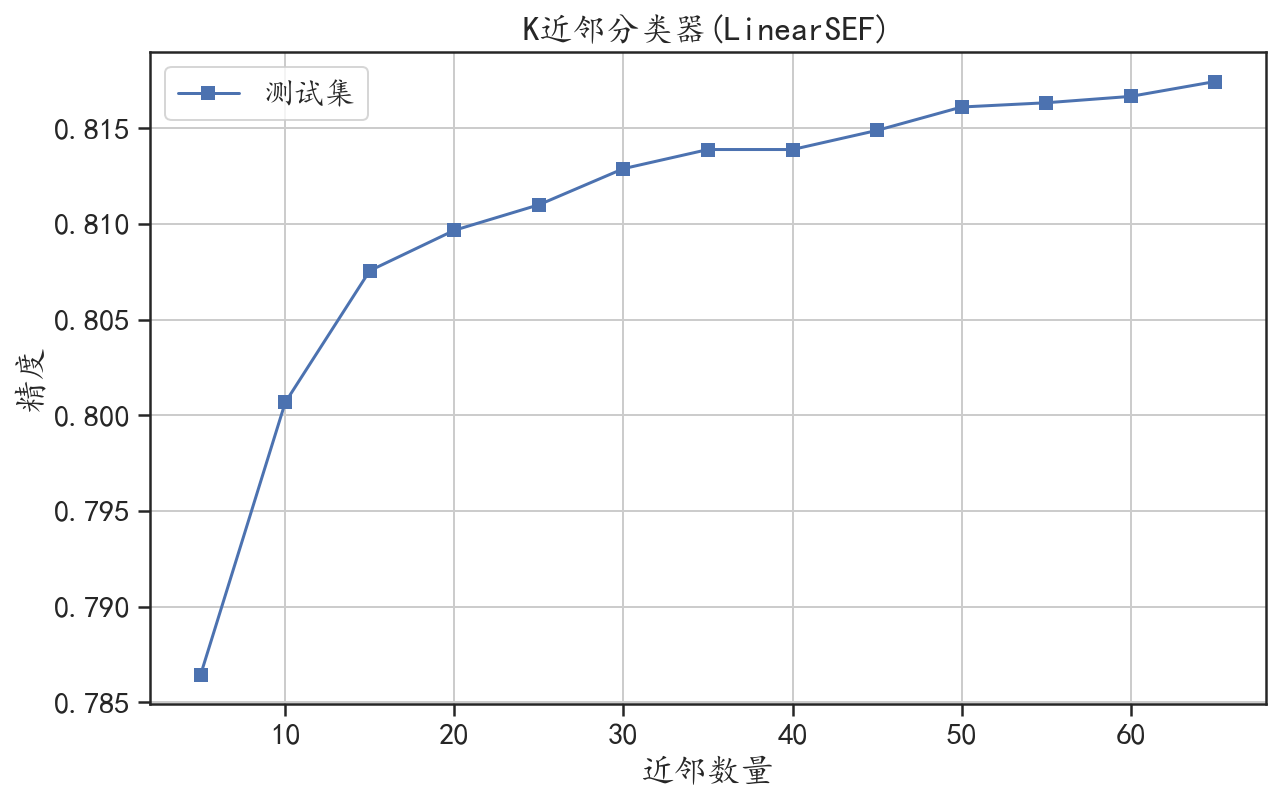

In [48]:
## 使用K近邻算法，分析不同的K值对测试集精度的影响
n_neighbors = np.arange(5,70,5)
test_acc = []
for n_neighbor in n_neighbors:
    knncla = KNeighborsClassifier(n_neighbors = n_neighbor,
                                  weights = "distance",n_jobs = 4)
    knncla.fit(X_train_sef,y_train.values) # 训练模型
    ## 计算测试集上的误差
    test_acc.append(knncla.score(X_test_sef,y_test.values))

## 结果可视化
plt.figure(figsize=(10,6))
## 可视化在测试集上的预测精度
plt.plot(n_neighbors,test_acc,"b-s",label = "测试集")
plt.legend()
plt.grid()
plt.xlabel("近邻数量")
plt.ylabel("精度")
plt.title("K近邻分类器(LinearSEF)")
plt.show()

#### 9.4.2 K近邻数据回归


In [49]:
## 读取用于K近邻回归的数据
housedf = pd.read_csv("data/chap9/USA_Housing.csv") 
housedf.head()

AvgAreaIncome  AvgAreaHouseAge  AvgAreaNumberRooms  \
0    79545.45857         5.682861            7.009188   
1    79248.64245         6.002900            6.730821   
2    61287.06718         5.865890            8.512727   
3    63345.24005         7.188236            5.586729   
4    59982.19723         5.040555            7.839388   

   AvgAreaNumberofBedrooms  AreaPopulation      AvgPrice  
0                     4.09     23086.80050  1.059034e+06  
1                     3.09     40173.07217  1.505891e+06  
2                     5.13     36882.15940  1.058988e+06  
3                     3.26     34310.24283  1.260617e+06  
4                     4.23     26354.10947  6.309435e+05

X_train.shape: (3750, 5)
X_test.shape: (1250, 5)


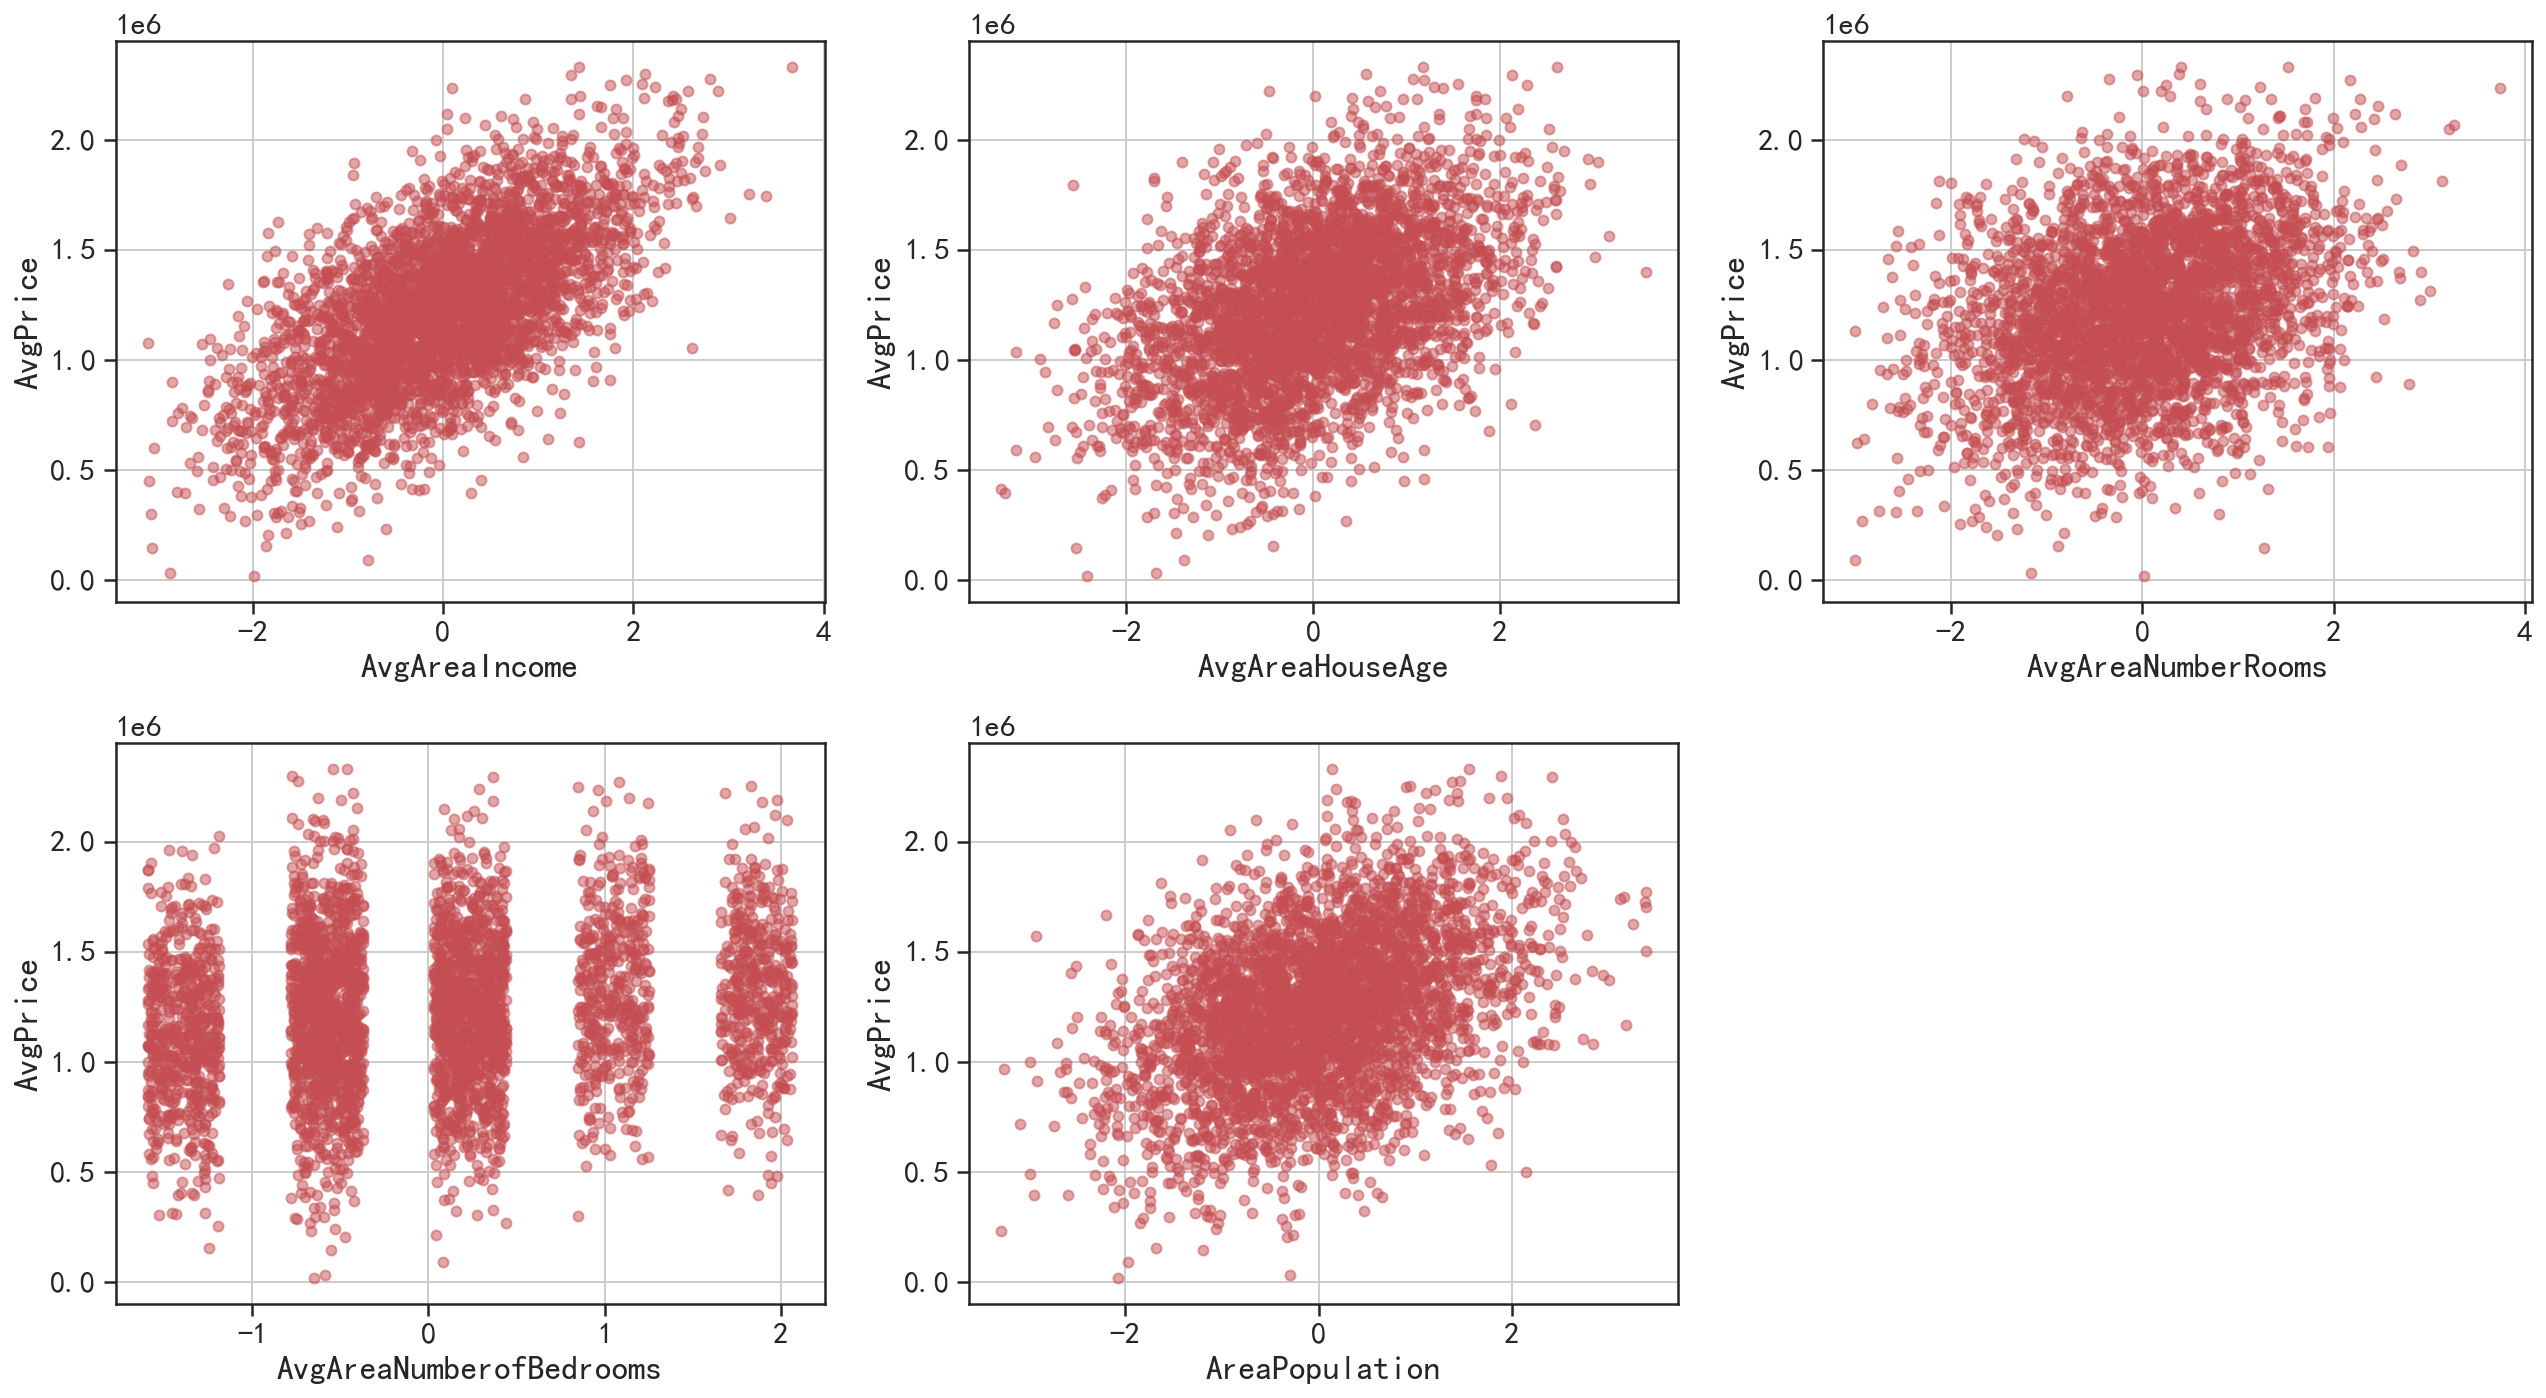

In [50]:
## 将数据切分为训练集和测试集，训练集75%，测试集25%
X_train,X_test,y_train,y_test = train_test_split(
    housedf.iloc[:,0:5],housedf["AvgPrice"],test_size = 0.25, random_state=0)
print("X_train.shape:",X_train.shape)
print("X_test.shape:",X_test.shape)


## 对数据进标准化预处理
std =  StandardScaler()
X_train_s = std.fit_transform(X_train)
X_test_s = std.transform(X_test)

## 对标准化后的数据特征进行可视化

## 对训练数据，可视化每个自变化和因变量之间的关系
plt.figure(figsize=(18,10))
for ii in np.arange(X_train_s.shape[1]):
    plt.subplot(2,3,ii+1)
    plt.plot(X_train_s[:,ii],y_train.values,"ro",
             markersize=5,alpha = 0.5)
    plt.grid()
    plt.xlabel(housedf.columns[ii])
    plt.ylabel(housedf.columns[-1])
plt.tight_layout()
plt.show()

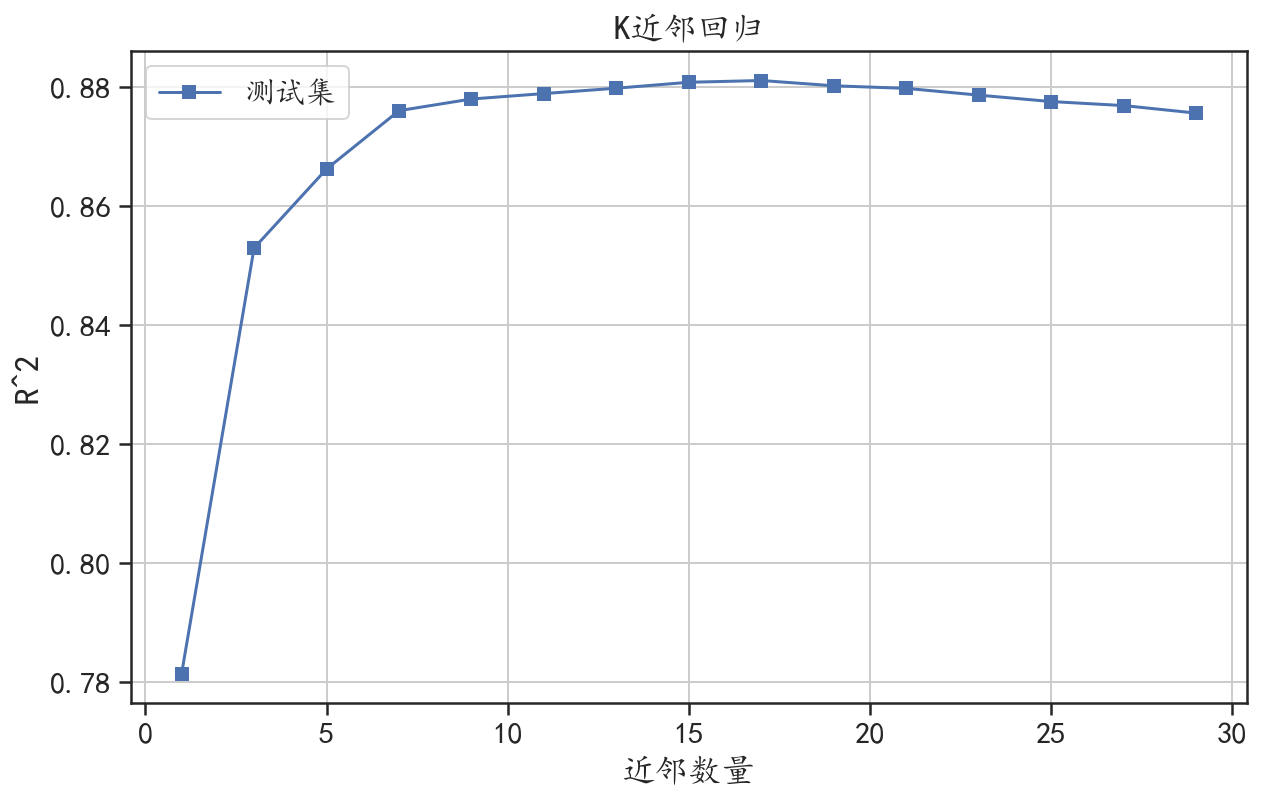

In [51]:
## 使用K近邻回归分析
n_neighbors = np.arange(1,30,2)
test_R2 = []
for n_neighbor in n_neighbors:
    knnreg = KNeighborsRegressor(n_neighbors = n_neighbor,
                                 weights = "distance",n_jobs = 4)
    knnreg.fit(X_train_s,y_train.values) # 训练模型
    ## 计算测试集上的误差
    test_R2.append(knnreg.score(X_test_s,y_test.values))

## 结果可视化
plt.figure(figsize=(10,6))
plt.plot(n_neighbors,test_R2,"b-s",label = "测试集")
plt.legend()
plt.grid()
plt.xlabel("近邻数量")
plt.ylabel("R^2")
plt.title("K近邻回归")
plt.show()

## 可以发现使用近邻数等于15或17时回归效果较好

In [52]:
## 计算K=15时在训练集和测试集上的预测误差
knnreg = KNeighborsRegressor(n_neighbors = 15,weights = "distance",n_jobs = 4)
knnreg.fit(X_train_s,y_train.values) # 训练模型
## 计算测试集上的误差
knnreg_pre = knnreg.predict(X_test_s)
print("在测试集上的平均绝对值误差为:",mean_absolute_error(y_test.values,knnreg_pre))

在测试集上的平均绝对值误差为: 99126.16386339697


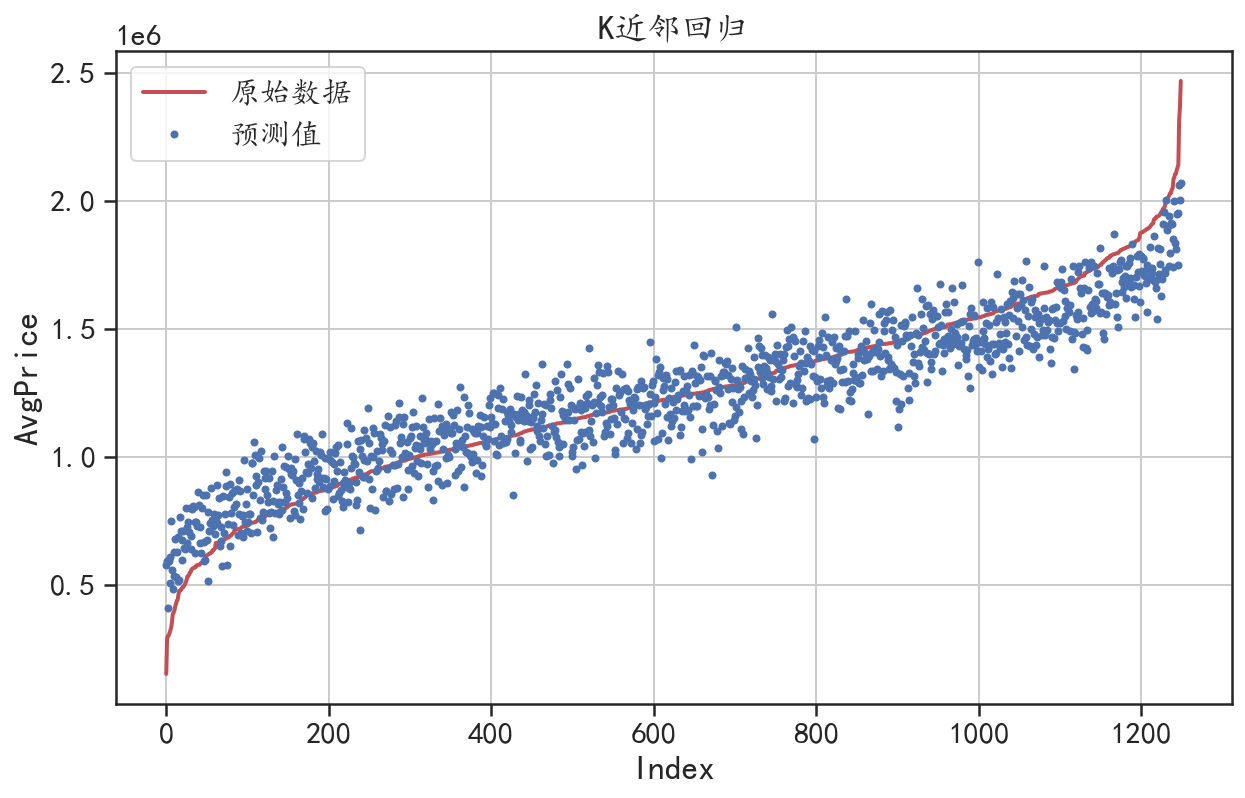

In [53]:
## 可视化预测结果和真实值之间的差距
plt.figure(figsize=(10,6))
index = np.argsort(y_test.values)
plt.plot(np.arange(len(index)),y_test.values[index],"r",
         linewidth=2, label = "原始数据")
plt.plot(np.arange(len(index)),knnreg_pre[index],"bo",
         markersize=3,label = "预测值")
plt.legend()
plt.grid()
plt.xlabel("Index")
plt.ylabel(housedf.columns[-1])
plt.title("K近邻回归")
plt.show()